# Сборный проект

## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных

`Name` — название игры

`Platform` — платформа

`Year_of_Release` — год выпуска

`Genre` — жанр игры

`NA_sales` — продажи в Северной Америке (миллионы проданных копий)

`EU_sales` — продажи в Европе (миллионы проданных копий)

`JP_sales` — продажи в Японии (миллионы проданных копий)

`Other_sales` — продажи в других странах (миллионы проданных копий)

`Critic_Score` — оценка критиков (максимум 100)

`User_Score` — оценка пользователей (максимум 10)

`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Необходимые библиотеки и настройки

In [553]:
!pip install missingno -q

In [554]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno

In [555]:
plt.style.use('seaborn')

In [556]:
pd.options.mode.chained_assignment = None

## Вспомогательные инструменты

In [557]:
def compare_two_hist(dfs, column_name, labels, xlabel, ylabel, title, stat_labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    sns.histplot(data=dfs[0], 
                 x=column_name, 
                 ax=ax, 
                 alpha=0.5, 
                 color='red', 
                 label=labels[0])

    sns.histplot(data=dfs[1], 
                 x=column_name, 
                 ax=ax, 
                 color='#C7F2A4', 
                 label=labels[1])

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.vlines(dfs[0][column_name].mean(), ymin=0, ymax=600, color='#1C6758', label=stat_labels[0])
    ax.vlines(dfs[1][column_name].mean(), ymin=0, ymax=600, ls='--', color='#8B5DFF', label=stat_labels[1])
    ax.legend();plt.show()


    
    

In [558]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

In [559]:
def outliers_report(df: pd.DataFrame, column_names , strategy: str):
    report = []
    for cn in column_names:
        if strategy == 'triple_sigma':
            mean = df[cn].mean()
            std = df[cn].std()
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@mean - 3 * @std > {cn}').shape[0],
            'left outliers %': df.query(f'@mean - 3 * @std > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@mean + 3 * @std < {cn}').shape[0],
            'right outliers %': df.query(f'@mean + 3 * @std < {cn}').shape[0] / df.shape[0] * 100   
        })
        elif strategy == 'iqr':
            q25 = df[cn].quantile(.25)
            q75 = df[cn].quantile(.75)
            iqr = q75 - q25
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0],
            'left outliers %': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0],
            'right outliers %': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0] / df.shape[0] * 100 
        })
    return pd.DataFrame(report).round(2)


In [560]:
def plot_graphics(df, column_name, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2', col_alias='', xlabel='', ylabel=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [561]:
def process_outliers(df: pd.DataFrame, column_name: str, strategy: str, do: str):
    df = df.copy()
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        if do == 'delete':
            return df.query(f'(@mean - 3 * @std < {column_name} < @mean + 3 * @std)')
        elif do == 'fill_na':
            df.loc[~(mean - 3 * std < df[f'{column_name}']) | ~(df[f'{column_name}'] < mean + 3 * std), f'{column_name}'] = np.nan
            return df
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        if do == 'delete':
            return df.query(f'( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')
        elif do == 'fill_na':
            df.loc[~(q25 - 1.5 * iqr < df[f'{column_name}']) | ~(df[f'{column_name}'] < q75 + 1.5 * iqr), f'{column_name}'] = np.nan
            return df

## Загрузка данных и изучение общей информации о датасете

In [ ]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('<PATH>')

In [563]:
df.sample(5)

Name Platform  \
8489                            Paws & Claws: Pet Resort      GBA   
323                                 Call of Duty: Ghosts      PS4   
970                              Guitar Hero: World Tour      PS2   
11532  Famicom Mini: SD Gundam World Gachapon Senshi ...      GBA   
4148              World of Warcraft: Warlords of Draenor       PC   

       Year_of_Release       Genre  NA_sales  EU_sales  JP_sales  Other_sales  \
8489            2006.0  Simulation      0.12      0.04      0.00         0.00   
323             2013.0     Shooter      1.78      1.43      0.05         0.57   
970             2008.0        Misc      1.00      0.03      0.00         0.77   
11532           2004.0    Strategy      0.00      0.00      0.08         0.00   
4148            2014.0      Action      0.08      0.36      0.00         0.03   

       Critic_Score User_Score Rating  
8489            NaN        NaN    NaN  
323            78.0        3.7      M  
970             NaN          8      T  
11532           NaN        NaN    NaN  
4148           87.0        5.9      T

In [564]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Видим, что в данных присутствуют разные типы - строки и числа. Подозрительным кажется, что `Critic_Score` имеет числовой тип, а `User_Score` - тип object. Необходимо с этим разобраться

Приведем названия всех колонок к нижнему регистру для удобства

In [565]:
df.columns = df.columns.str.lower()

Попробуем построить первые гистограммы по числовым колонкам датасета

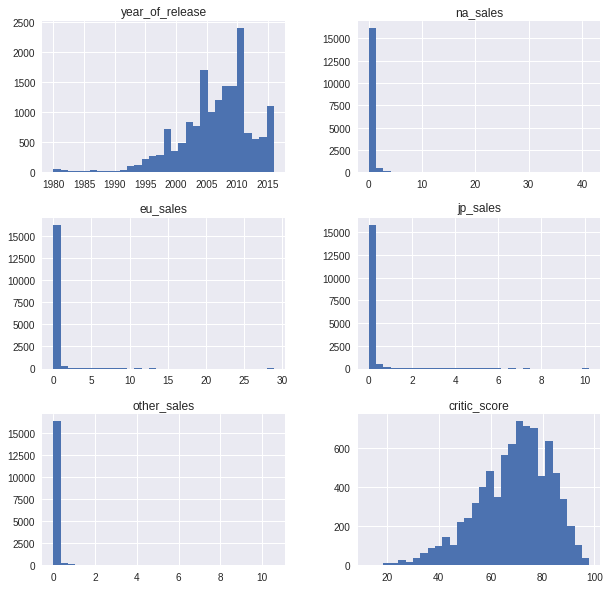

In [566]:
df.hist(bins=30, figsize=(10, 10));plt.show()

- Видим, что данные по продажам имеют сильный пик в области малых значений
- Гистограмма по `critic_score` несколько локальных максимумов. 
- По гистограмме `year_of_release` видно, что мы имеем дело с данными примерно с 1980 по 2015 год. Есть несколько максимумов 


проверим это сводными статистиками по данной колонке

In [567]:
df[['year_of_release']].describe()

year_of_release
count     16446.000000
mean       2006.484616
std           5.877050
min        1980.000000
25%        2003.000000
50%        2007.000000
75%        2010.000000
max        2016.000000

## Предобработка данных

### Анализ пропущенных значений

In [568]:
missings = pd.concat([df.isna().sum().T,  df.isna().mean().T * 100], axis=1).set_axis(['Количество пропусков','Процент пропусков'], axis=1).round(2)
missings

Количество пропусков  Процент пропусков
name                                2               0.01
platform                            0               0.00
year_of_release                   269               1.61
genre                               2               0.01
na_sales                            0               0.00
eu_sales                            0               0.00
jp_sales                            0               0.00
other_sales                         0               0.00
critic_score                     8578              51.32
user_score                       6701              40.09
rating                           6766              40.48

визуализируем данные на столбчатой диаграмме

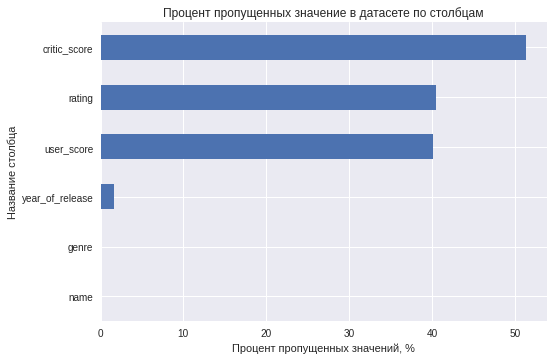

In [569]:
(missings.loc[missings['Процент пропусков'] > 0, 'Процент пропусков']
 .sort_values()
 .plot(kind='barh', title='Процент пропущенных значение в датасете по столбцам'))
plt.xlabel('Процент пропущенных значений, %')
plt.ylabel('Название столбца')
plt.show()

- Видим, что более 50% значений в столбце `critic_score` - пропуски

- Также около 40% пропущенных значений в столбцах `rating` и `user_score`

- Меньше всего пропусков в столбцах `genre` и `name`

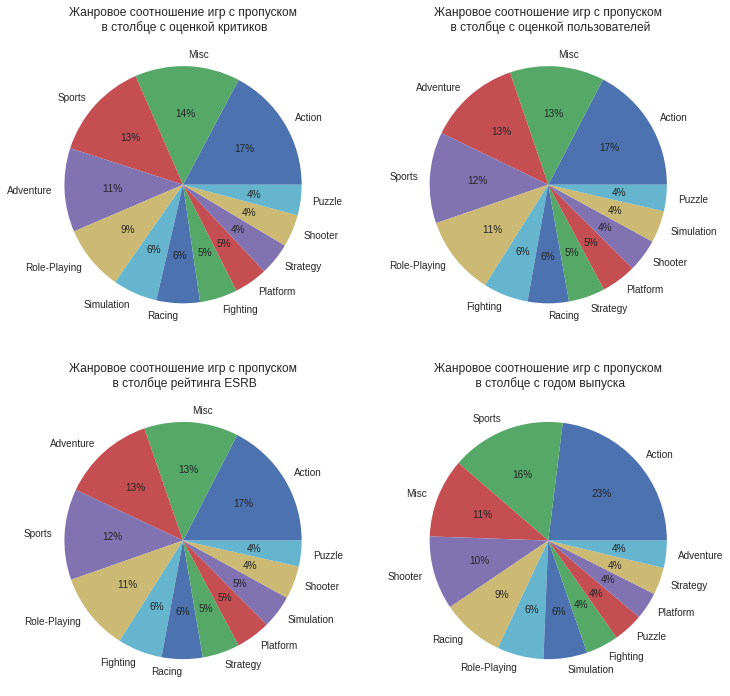

In [570]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

(df[df.critic_score.isna()]
 .genre
 .value_counts()
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Жанровое соотношение игр c пропуском\n в столбце с оценкой критиков',
       ax=ax[0][0]
      ))


(df[df.user_score.isna()]
 .genre
 .value_counts()
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Жанровое соотношение игр c пропуском\n в столбце с оценкой пользователей',
       ax=ax[0][1]))

(df[df.rating.isna()]
 .genre
 .value_counts()
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Жанровое соотношение игр c пропуском\n в столбце рейтинга ESRB',
       ax=ax[1][0]
       ))

(df[df.year_of_release.isna()]
 .genre
 .value_counts()
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Жанровое соотношение игр c пропуском\n в столбце с годом выпуска',
       ax=ax[1][1]
       ))
plt.show()


- По жанрам распределения пропусков в столбцах c рейтингом очень похожи, 
- Больше всего пропусков в экшн играх

Теперь посмотрим на взаимосвязь пропусков и визуализируем с помощью тепловой карты

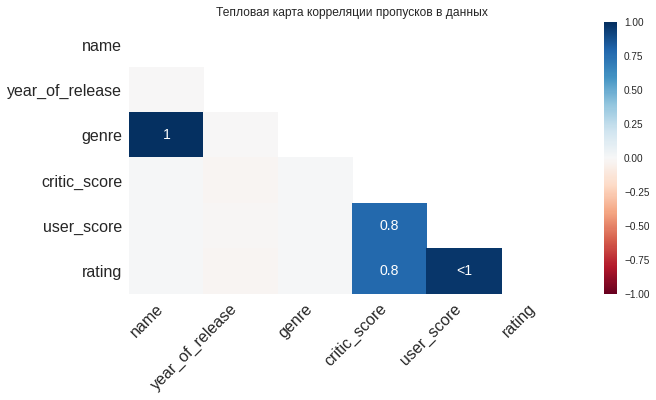

In [571]:
ax = msno.heatmap(df, figsize=(10, 5))
ax.set_title('Тепловая карта корреляции пропусков в данных');plt.show()

- Если пропуск есть в столбца `genre`, то он обязательно есть в столбце `name`

- Очень сильная зависимость между пропусками в столбцах `user_score` и `rating`. То есть, если пропуск есть в одном из столбцов, то он с очень большой вероятностью есть и в другом столбце

-  Сильная связь между пропусками в столбцах `critic_score`, `user_score` и `rating`

- Организация ESRB может штрафовать компьютерные игры, если они были уличены в сокрытии контента, такая игра может быть даже удалена из интернет магазинов. Поэтому, возможно, что части игр не был присвоен ретинг ESRB. В таком случае, ее могли не увидеть пользователи и критики, отсюда и сильная взаимосвязь между тремя видами рейтингов (пользовательский, критический и ESRB)

- Кроме того, пропуски в столбцах `user_score` и `critic_score` могли появиться в силу малой популярности игры

- Пропуски в столбце `year_of_release` могли быть технической ошибкой

<b>Что делаем с пропусками?</b>

- `year_of_release`: всего 1.61% пропусков, заполнить их чем-то невозможно, заполним индикаторным значением -1

- `critic_score`, `user_score`, `rating`: `critic_score`, `user_score` заменим индикаторным значением -1, `rating` - на 'norating'

- `name`, `genre`: заполним на 'NA'

### Заполнение пропусков

In [572]:
df['year_of_release'].fillna(-1, inplace=True)

In [573]:
df['critic_score'].fillna(-1, inplace=True)
df['user_score'].fillna(-1, inplace=True)
df['rating'].fillna('norating', inplace=True)
df['genre'].fillna('NA', inplace=True)
df['name'].fillna('NA', inplace=True)

Проверим пропуски еще раз

In [574]:
missings = pd.concat([df.isna().sum().T,  df.isna().mean().T * 100], axis=1).set_axis(['Количество пропусков','Процент пропусков'], axis=1).round(2)
missings

Количество пропусков  Процент пропусков
name                                0                0.0
platform                            0                0.0
year_of_release                     0                0.0
genre                               0                0.0
na_sales                            0                0.0
eu_sales                            0                0.0
jp_sales                            0                0.0
other_sales                         0                0.0
critic_score                        0                0.0
user_score                          0                0.0
rating                              0                0.0

### Обработка значения `tbd` в столбце `user_score`

tbd - это аббревиатура выражения "to be determined". То есть, это значение еще не определено, заполним его значением -1

In [575]:
tbd = df.query('user_score == "tbd"')
tbd

name platform  year_of_release  \
119                               Zumba Fitness      Wii           2010.0   
301              Namco Museum: 50th Anniversary      PS2           2005.0   
520                             Zumba Fitness 2      Wii           2011.0   
645                                uDraw Studio      Wii           2010.0   
657    Frogger's Adventures: Temple of the Frog      GBA             -1.0   
...                                         ...      ...              ...   
16695                           Planet Monsters      GBA           2001.0   
16697                          Bust-A-Move 3000       GC           2003.0   
16698                          Mega Brain Boost       DS           2008.0   
16704                                  Plushees       DS           2008.0   
16706             Men in Black II: Alien Escape       GC           2003.0   

            genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
119        Sports      3.45      2.59       0.0         0.66          -1.0   
301          Misc      2.08      1.35       0.0         0.54          61.0   
520        Sports      1.51      1.03       0.0         0.27          -1.0   
645          Misc      1.65      0.57       0.0         0.20          71.0   
657     Adventure      2.15      0.18       0.0         0.07          73.0   
...           ...       ...       ...       ...          ...           ...   
16695      Action      0.01      0.00       0.0         0.00          67.0   
16697      Puzzle      0.01      0.00       0.0         0.00          53.0   
16698      Puzzle      0.01      0.00       0.0         0.00          48.0   
16704  Simulation      0.01      0.00       0.0         0.00          -1.0   
16706     Shooter      0.01      0.00       0.0         0.00          -1.0   

      user_score rating  
119          tbd      E  
301          tbd   E10+  
520          tbd      T  
645          tbd      E  
657          tbd      E  
...          ...    ...  
16695        tbd      E  
16697        tbd      E  
16698        tbd      E  
16704        tbd      E  
16706        tbd      T  

[2424 rows x 11 columns]

Таких строк 2424 в датасете

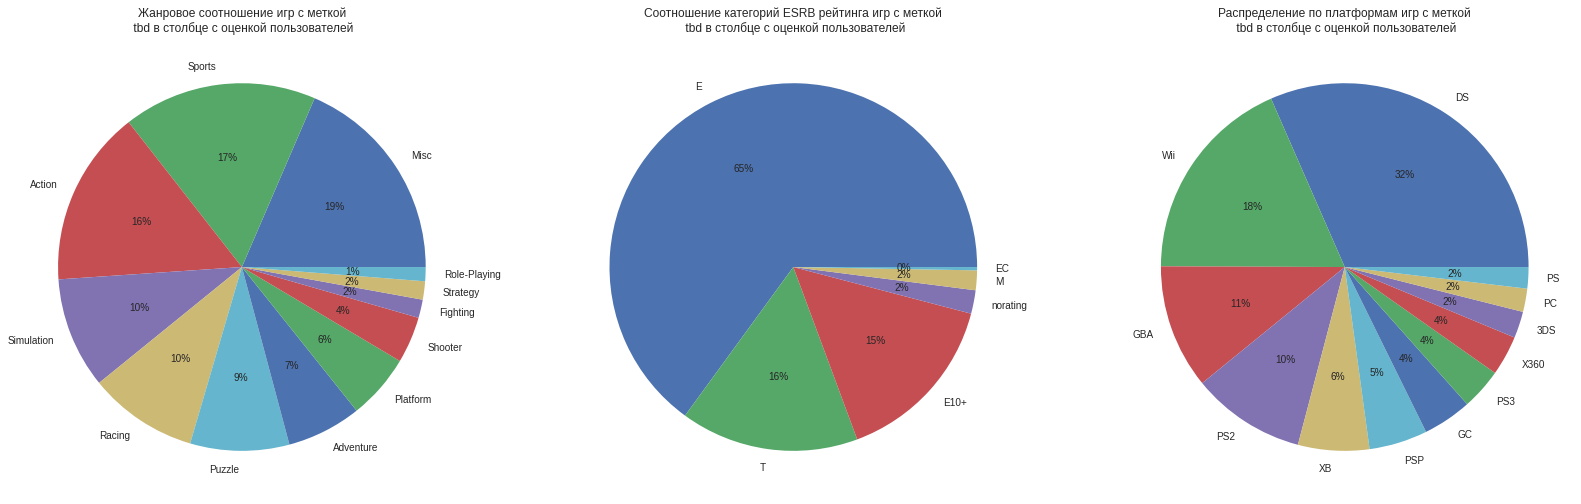

In [576]:
fig, ax = plt.subplots(1, 3, figsize=(28, 20))

(tbd
 .genre
 .value_counts()
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Жанровое соотношение игр с меткой\n tbd в столбце с оценкой пользователей',
       ax=ax[0]))


(tbd
 .rating
 .value_counts()
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Соотношение категорий ESRB рейтинга игр с меткой\n tbd в столбце с оценкой пользователей',
       ax=ax[1]))


tmp = tbd.platform.value_counts()
(tmp[tmp > 20]
 .plot(kind='pie',
       autopct = "%.0f%%",
       ylabel= "",
       title='Распределение по платформам игр с меткой\n tbd в столбце с оценкой пользователей',
       ax=ax[2]))

plt.show()

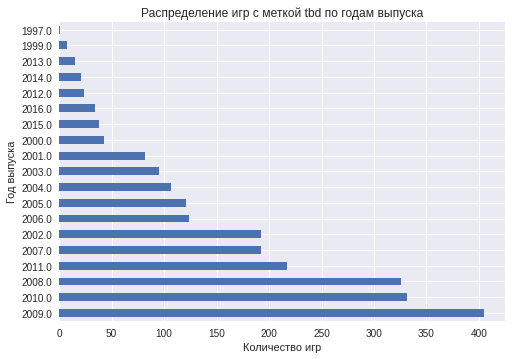

In [577]:
(tbd
 .query('year_of_release != -1')
 .year_of_release.value_counts()
 .plot(kind='barh', 
       title='Распределение игр с меткой tbd по годам выпуска'))

plt.xlabel('Количество игр')
plt.ylabel('Год выпуска')
plt.show()

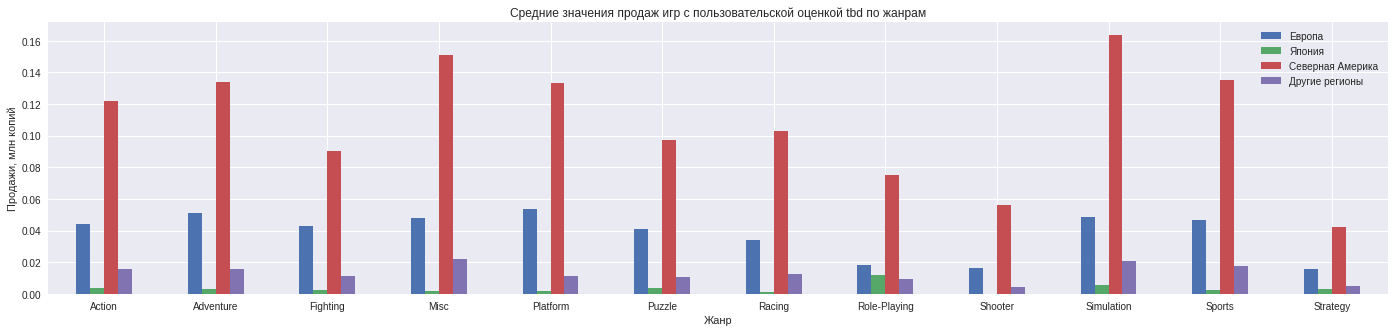

In [578]:
piv = tbd.pivot_table(index='genre', values=['na_sales', 'jp_sales', 'eu_sales', 'other_sales'])
piv.plot(kind='bar', title='Средние значения продаж игр c пользовательской оценкой tbd по жанрам', figsize=(24, 5))
plt.xlabel('Жанр')
plt.xticks(rotation=0)
plt.ylabel('Продажи, млн копий')
plt.legend(['Европа', 'Япония', 'Северная Америка', 'Другие регионы'])
plt.show()

- Видим, что больше всего продаж таких игр происходило в Северной Америке и Европе
- В Японии такие игры наиболее продаваемы в жанре `Role-Playing`
- В Европе такие игры наиболее продаваемы в жанре `Platform`
- В Северной Америке такие игры наиболее продаваемы в жанре `Simulation`
- В других регионах такие игры наиболее продаваемы в жанре `Misc`

In [579]:
df.loc[df.user_score == 'tbd', 'user_score'] = -1

- Итак, дополнительно было выяснено, что значение tbd присутствует в 2124 строках датасета
- Большинство игр из этой категории принадлежат жанрам `Разное`, `Спорт`, `Экшн`
- 66% игр из этой категории были оценены организацией ESRB рейтингом `E`, 16% рейтингом `T`, 15% рейтингом `E10+`
- Максимум пришелся на игры, выпущенные в 2009 году
- А большая часть таких игр представлена на платформах `DS`, `Wii`, `GBA` и `PS2`

### Изменение типов столбцов

In [580]:
df['year_of_release'] = df['year_of_release'].astype(np.int32)
df['user_score'] = df['user_score'].astype(float)

In [581]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  float64
 10  rating           16715 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


### Проверка на дубликаты

Заметим, что в столбце `name` есть дубликаты, значит в данных есть одинаковые игры, представленные на различных платформах

In [582]:
df['name'].duplicated().sum()

5155

### Исследование аномальных значений

In [583]:
outliers_report(df, ['na_sales', 'eu_sales', 'other_sales', 'jp_sales'], 'iqr')

column_name  left outliers count  left outliers %  right outliers count  \
0     na_sales                    0              0.0                  1687   
1     eu_sales                    0              0.0                  2061   
2  other_sales                    0              0.0                  2243   
3     jp_sales                    0              0.0                  2434   

   right outliers %  
0             10.09  
1             12.33  
2             13.42  
3             14.56

In [584]:
outliers_report(df.query('critic_score != -1 and user_score != -1'), ['critic_score', 'user_score'], 'iqr')

column_name  left outliers count  left outliers %  right outliers count  \
0  critic_score                  110             1.57                     0   
1    user_score                  273             3.89                     0   

   right outliers %  
0               0.0  
1               0.0

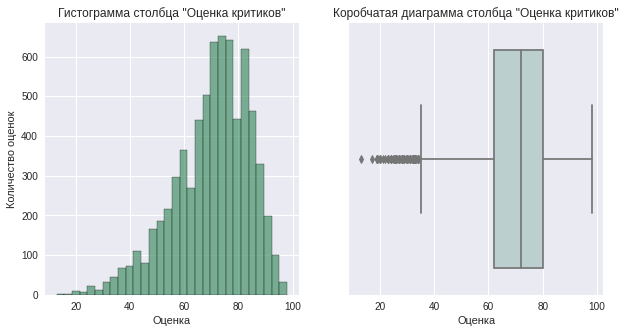

In [585]:
plot_graphics(df.query('critic_score != -1 and user_score != -1'), 'critic_score', col_alias='"Оценка критиков"', xlabel='Оценка', ylabel='Количество оценок')

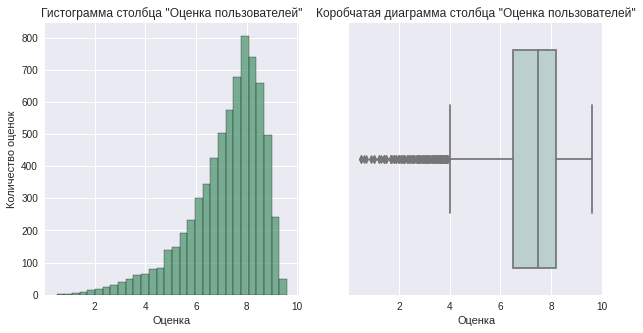

In [586]:
plot_graphics(df.query('critic_score != -1 and user_score != -1'), 'user_score', col_alias='"Оценка пользователей"', xlabel='Оценка', ylabel='Количество оценок')

Есть левые хвосты на гистограммах: низкие оценки как пользователей, так и критиков. Ничего особенного нет, в указанный масштаб величины укладываются

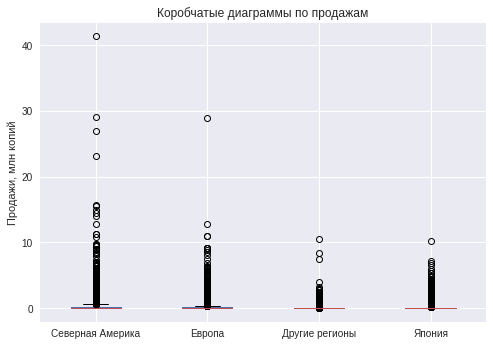

In [587]:
(df[['na_sales', 'eu_sales', 'other_sales', 'jp_sales']]
 .set_axis(['Северная Америка', 'Европа', 'Другие регионы', 'Япония'], axis=1)
 .plot(kind='box', title="Коробчатые диаграммы по продажам"))

plt.ylabel('Продажи, млн копий')
plt.show()

Видим, что все выбросы - аномально большие значения, то есть аномально хорошо продаваемые игры

In [588]:
TOP_CONST = 15
na_sales_outliers = detect_outliers(df, 'na_sales', 'iqr').sort_values('na_sales', ascending=False)[:TOP_CONST]
jp_sales_outliers = detect_outliers(df, 'jp_sales', 'iqr').sort_values('jp_sales', ascending=False)[:TOP_CONST]
eu_sales_outliers = detect_outliers(df, 'eu_sales', 'iqr').sort_values('eu_sales', ascending=False)[:TOP_CONST]
other_sales_outliers = detect_outliers(df, 'other_sales', 'iqr').sort_values('other_sales', ascending=False)[:TOP_CONST]

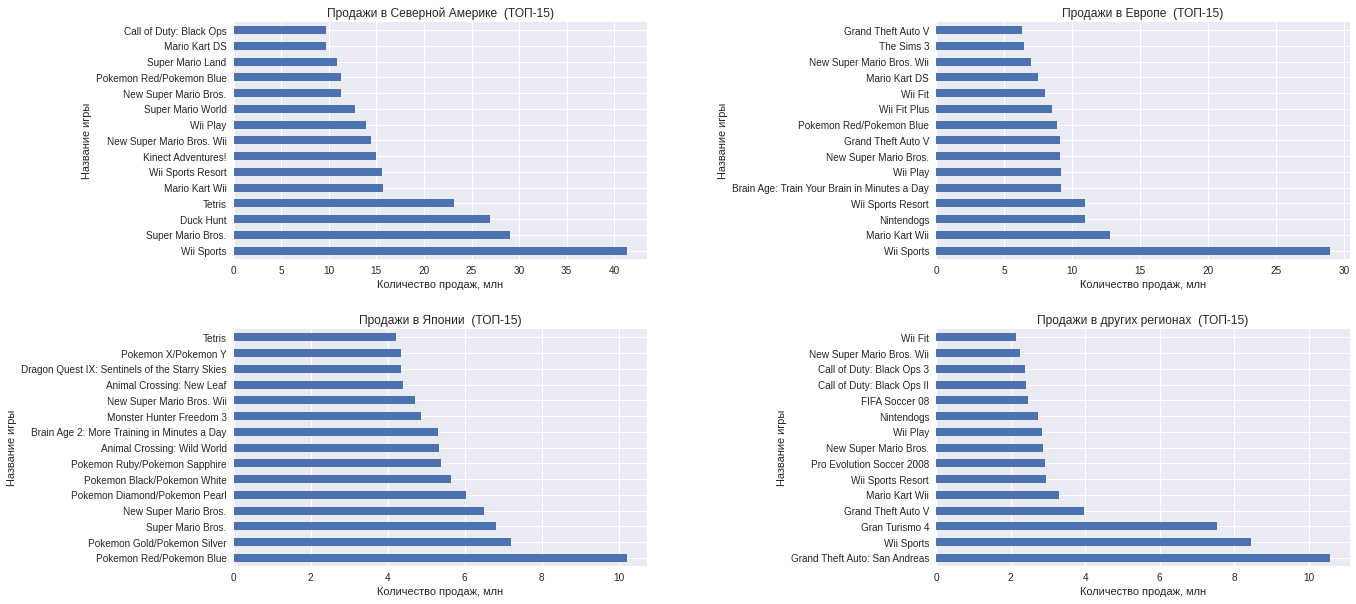

In [589]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

fig.subplots_adjust(wspace=.7, hspace=0.3)

outliers_df = [[na_sales_outliers, eu_sales_outliers], [jp_sales_outliers, other_sales_outliers]]
columns = [['na_sales', 'eu_sales'], ['jp_sales', 'other_sales']]
regions = [['Северной Америке', 'Европе'], ['Японии', 'других регионах']]
common_title = lambda x: f'Продажи в {x}  (ТОП-{TOP_CONST})'
for i in range(2):
    for j in range(2):
        outliers_df[i][j].plot(kind='barh', x='name', y=columns[i][j], title=common_title(regions[i][j]), legend=False, ax=ax[i][j])
        ax[i][j].set_xlabel('Количество продаж, млн')
        ax[i][j].set_ylabel('Название игры')

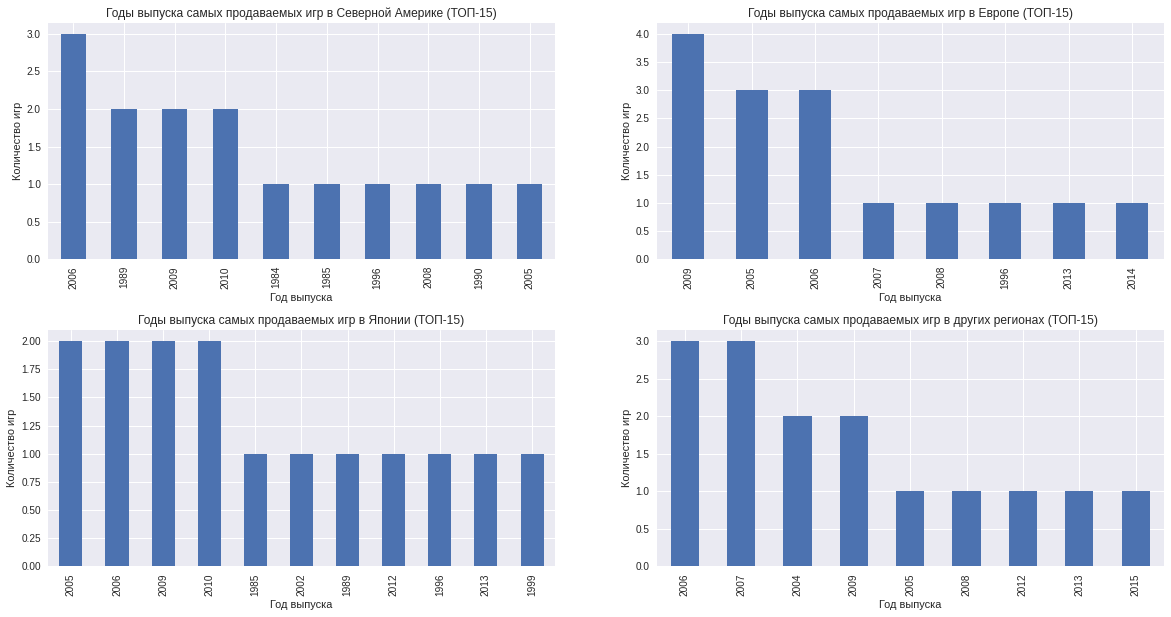

In [590]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

fig.subplots_adjust(hspace=0.3)

outliers_df = [[na_sales_outliers, eu_sales_outliers], [jp_sales_outliers, other_sales_outliers]]
columns = [['na_sales', 'eu_sales'], ['jp_sales', 'other_sales']]
regions = [['Северной Америке', 'Европе'], ['Японии', 'других регионах']]
explore_column = 'year_of_release'
common_title = lambda x: f'Годы выпуска самых продаваемых игр в {x} (ТОП-{TOP_CONST})'

for i in range(2):
    for j in range(2):
        (outliers_df[i][j][explore_column]
         .value_counts()
         .plot(kind='bar', x='name', y=columns[i][j], title=common_title(regions[i][j]), legend=False, ax=ax[i][j]))
        
        ax[i][j].set_ylabel('Количество игр')
        ax[i][j].set_xlabel('Год выпуска')

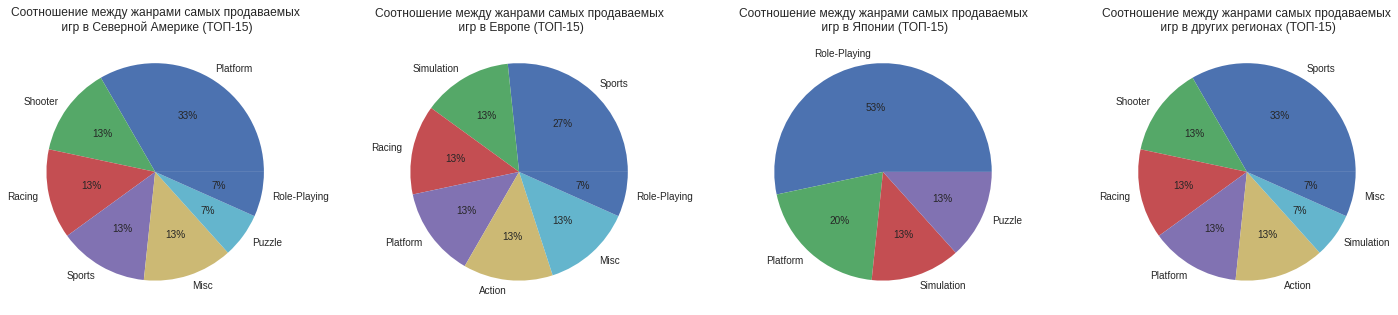

In [591]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

fig.subplots_adjust(hspace=0.3)

outliers_df = [na_sales_outliers, eu_sales_outliers, jp_sales_outliers, other_sales_outliers]
columns = ['na_sales', 'eu_sales','jp_sales', 'other_sales']
regions = ['Северной Америке', 'Европе', 'Японии', 'других регионах']
explore_column = 'year_of_release'
common_title = lambda x: f'Соотношение между жанрами самых продаваемых\n игр в {x} (ТОП-{TOP_CONST})'


for i in range(4):
        (outliers_df[i].genre.value_counts()
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         title=common_title(regions[i]),
         ax=ax[i]))

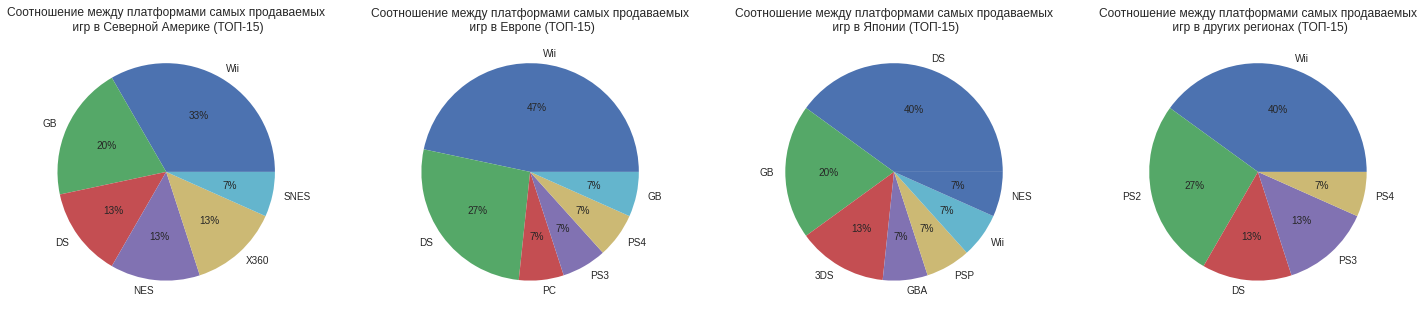

In [592]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

fig.subplots_adjust(hspace=0.3)

outliers_df = [na_sales_outliers, eu_sales_outliers, jp_sales_outliers, other_sales_outliers]
columns = ['na_sales', 'eu_sales','jp_sales', 'other_sales']
regions = ['Северной Америке', 'Европе', 'Японии', 'других регионах']
explore_column = 'year_of_release'
common_title = lambda x: f'Соотношение между платформами самых продаваемых\n игр в {x} (ТОП-{TOP_CONST})'


for i in range(4):
        (outliers_df[i].platform.value_counts()
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         title=common_title(regions[i]),
         ax=ax[i],
              ))

- Северная Америка
1. Аномальные продажи игры `Wii Sports` превалируют среди других игр
2. Лучший год по количеству выпущенных и самых продаваемых игр - 2006 год
3. Среди самых продаваемых игр преобладает платформа `Wii`, вторая по популярности - `GB`
4. Среди самых продаваемых игр преобладают жанры `Platform` и `Sports`

- Европа
1. Аналогична, игра `Wii Sports` пользуется наибольшим спросом
2. Однако наиболее удачный год выпуска по самым продаваемым играм - 2009
3. Почти половина из ТОП-15 самых продаваемых игр выпускалось под плтформу `Wii`, вторая по популярности - `DS`
4. Среди самых продаваемых игр преобладают жанры `Sports` и `Racing`

- Япония
1. Совершенно другая игра - `pokemon red/ pokemon blue` - пользуется наибольшим спросом
2. Наиболее частый год выпуска самых продаваемых игр - 2005, 2006, 2009, 2010
3. Почти половина из ТОП-15 самых продаваемых игр выпускалось под плтформу `DS`, вторая по популярности - `GB`
4. Среди самых продаваемых самые популярные в жанре `Role-playing`, второй по популярности жанр - `platform`

- Другие регионы
1. Наиболее высоким спросом пользуется игра `Grand Theft Auto: San Andreas`
2. Наиболее частый год выпуска самых продаваемых игр - 2006 и 2007
3. Почти половина из ТОП-15 самых продаваемых игр выпускалось под плтформу `Wii`, вторая по популярности - `PS2`
4. Среди самых продаваемых самые популярные в жанре `Sports`, второй по популярности жанр - `action`


- Причем на самом деле никаких аномалий здесь нет. Перечисленные платформы и игры действительно пользовались огромной популярностью в свое время, отсюда и столь высокие продажи
- 2006 год фигурирует часто, так как именно в 2006 году переименовали популярную платформу Revolution в платформу Wii

### Суммарные продажи

In [593]:
df['summary_sales'] = df[['other_sales', 'na_sales', 'eu_sales', 'other_sales']].sum(axis=1)



- Пропущенных значений было достаточно много, числовые столбцы заполнены индикаторным значением, строковые - значениями-индикаторами `NA` и `norating`
- Исследовали аномальные значения и составили портреты самых продаваемых игр и платформ по регионам
- Заменили типы данных
- Провели проверку на явные дубликаты
- Исследовали значение `tbd` и распределения продаж, которые ему соответствуют

## Работа со столбцами

### Столбец `platform`

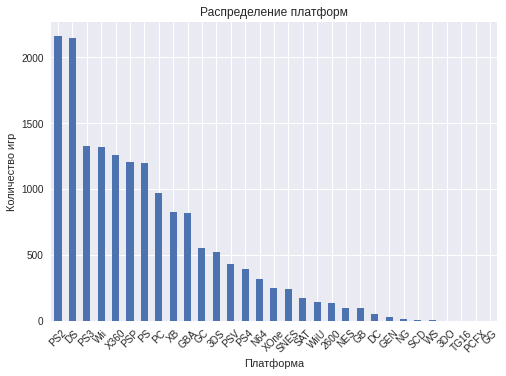

In [594]:
df.platform.value_counts().plot(kind='bar', title='Распределение платформ')
plt.ylabel('Количество игр')
plt.xlabel('Платформа')
plt.xticks(rotation=45)
plt.show()

In [595]:
df['ps'] = df['platform'].apply(lambda x: 'PS' if "PS" in x else 'no')

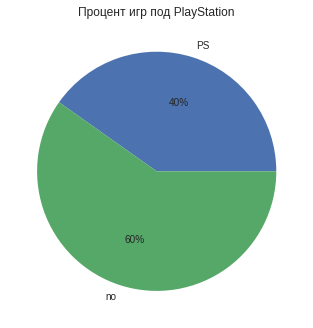

In [596]:
piv = df.pivot_table(index='ps', values='name', aggfunc='count').set_axis(['count'], axis=1).plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='count',
         legend=False,
         title='Процент игр под PlayStation',
         )


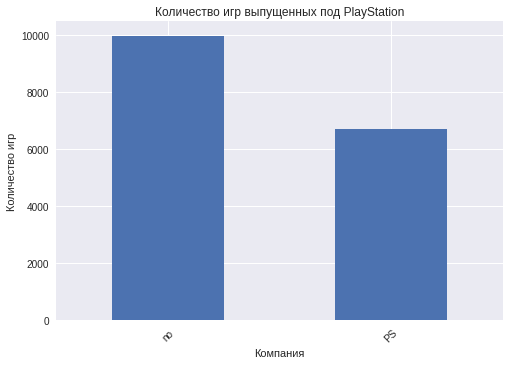

In [597]:
ax = df.ps.value_counts().plot(kind='bar', title='Количество игр выпущенных под PlayStation')
plt.ylabel('Количество игр')
plt.xlabel('Компания')
plt.xticks(rotation=45)
plt.show()

- Наиболее популярны платформы PS2 и DS
- Около 40% игр выпущено под платформы PlayStation

### Столбец `rating`

<AxesSubplot:>

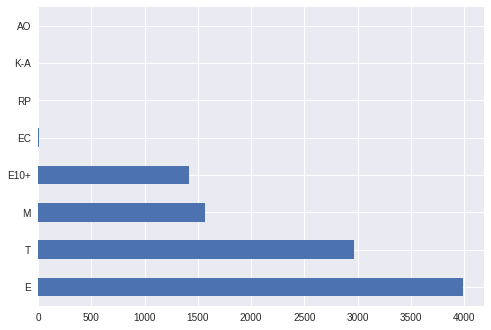

In [598]:
df.query('rating != "norating"').rating.value_counts().plot(kind='barh')

- Превалирует рейтинг `E` (для всех)
- Также популярны рейтинги `T` (для подростков) и `M` (для взрослых)

### Столбец `user_score`

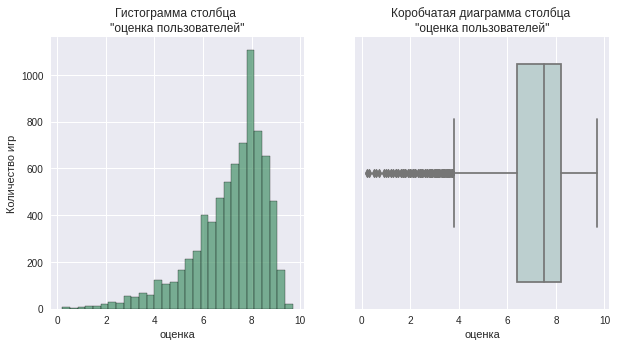

In [599]:
plot_graphics(df.query('user_score > 0'), 'user_score', col_alias='\n"оценка пользователей"', xlabel='оценка', ylabel='Количество игр')

In [600]:
df.loc[df['user_score'] > 0, 'user_score_group'] = df['user_score'].apply(lambda x: 'низкая оценка' if x < 4 else 'нормальная оценка')

Text(0, 0.5, 'Группа оценок')

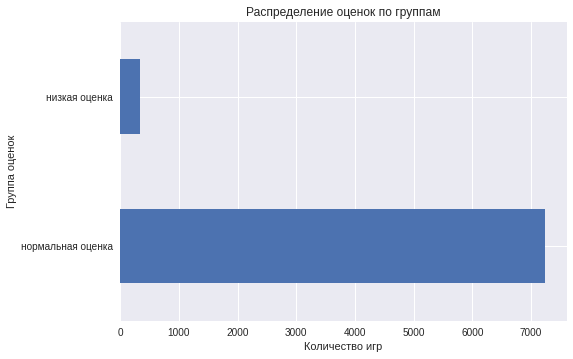

In [601]:
ax = df.query('user_score > 0').user_score_group.value_counts().plot(kind='barh', title='Распределение оценок по группам')
plt.xlabel('Количество игр')
plt.ylabel('Группа оценок')

<AxesSubplot:title={'center':'Платформы с низкой оценкой'}>

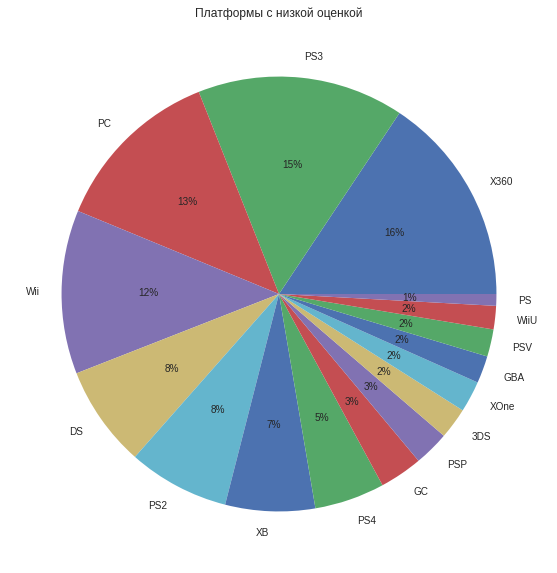

In [602]:
df.query('user_score > 0 and user_score_group == "низкая оценка"').platform.value_counts().plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         legend=False,
         figsize=(10,10),
         title='Платформы с низкой оценкой',
         )

<AxesSubplot:title={'center':'ТОП игр с низкими оценками'}>

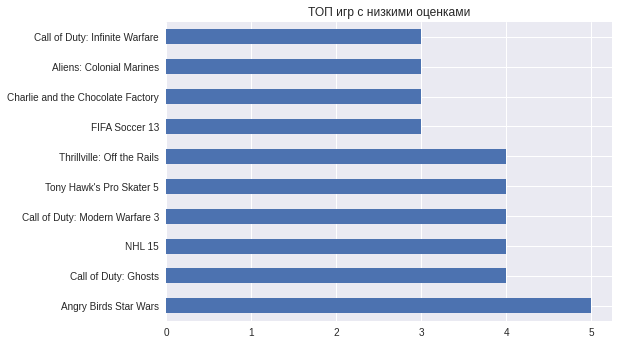

In [603]:
data = df.query('user_score > 0 and user_score_group == "низкая оценка"').name.value_counts()
data[data > 2].plot(kind='barh',
         title='ТОП игр с низкими оценками',
         )

In [604]:
df.query('name == "Angry Birds Star Wars"')

name platform  year_of_release     genre  na_sales  \
5431   Angry Birds Star Wars      3DS             2013  Strategy      0.15   
6047   Angry Birds Star Wars      PS3             2013  Strategy      0.10   
6217   Angry Birds Star Wars     X360             2013  Strategy      0.16   
6443   Angry Birds Star Wars      Wii             2013  Strategy      0.15   
7296   Angry Birds Star Wars      PS4             2013  Strategy      0.10   
8607   Angry Birds Star Wars     XOne             2013  Strategy      0.11   
10755  Angry Birds Star Wars     WiiU             2013  Strategy      0.05   
11339  Angry Birds Star Wars      PSV             2013  Strategy      0.03   

       eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
5431       0.15       0.0         0.03          -1.0         3.0      E   
6047       0.14       0.0         0.05          49.0         3.6      E   
6217       0.10       0.0         0.02          59.0         5.6      E   
6443       0.09       0.0         0.02          -1.0         2.8      E   
7296       0.08       0.0         0.04          47.0         2.0      E   
8607       0.04       0.0         0.02          53.0         6.9      E   
10755      0.04       0.0         0.01          -1.0         6.8      E   
11339      0.03       0.0         0.02          -1.0         2.0      E   

       summary_sales  ps   user_score_group  
5431            0.36  no      низкая оценка  
6047            0.34  PS      низкая оценка  
6217            0.30  no  нормальная оценка  
6443            0.28  no      низкая оценка  
7296            0.26  PS      низкая оценка  
8607            0.19  no  нормальная оценка  
10755           0.11  no  нормальная оценка  
11339           0.10  PS      низкая оценка

Еще посмотрим на связь пользовательских и критических оценок

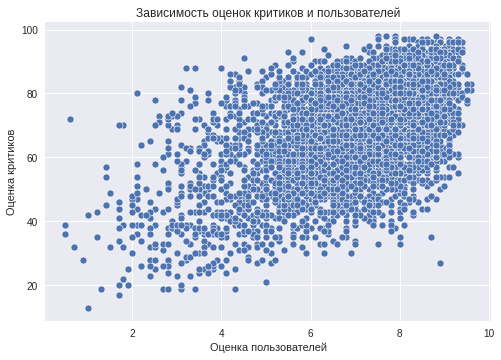

In [605]:
sns.scatterplot(data=df.query('user_score > 0 and critic_score > 0'), x='user_score', y='critic_score')
plt.xlabel('Оценка пользователей')
plt.ylabel('Оценка критиков')
plt.title('Зависимость оценок критиков и пользователей')
plt.show()

In [606]:
tmp = df.query('user_score > 0 and critic_score > 0')
tmp.user_score.corr(tmp.critic_score)

0.5808778320767236

- Действительно низких оценок достаточно мало
- Больше всего низких оценок поставлено пользователями играм на платформе X360 и PS3
- Самая низко оцененная игра - Angry Birds Star Wars. Причем и критики оценили ее не высоко (до 60 баллов)
- Оценки пользователей имеют довольно любопытную связь, их коэффициент корреляции около 0.6

### Столбец `critic_score`

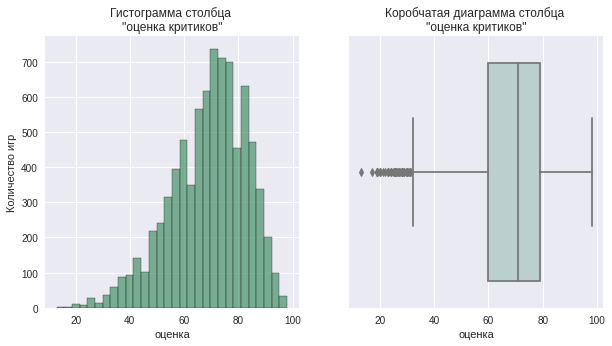

In [607]:
plot_graphics(df.query('critic_score > 0'), 'critic_score', col_alias='\n"оценка критиков"', xlabel='оценка', ylabel='Количество игр')

Очень похоже на нормальное распределение, но есть левые хвост с очень низкими оценками критиков

In [608]:
tmp = df.query('critic_score > 0')
tmp['critic_score_group'] = tmp['critic_score'].apply(lambda x: 'низкая оценка' if x < 30 else 'нормальная оценка')

Text(0, 0.5, 'Группа оценок')

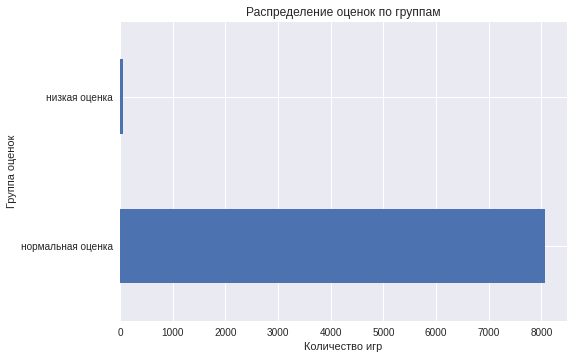

In [609]:
ax = tmp.query('critic_score > 0').critic_score_group.value_counts().plot(kind='barh', title='Распределение оценок по группам')
plt.xlabel('Количество игр')
plt.ylabel('Группа оценок')

<AxesSubplot:title={'center':'Платформы с низкой оценкой'}>

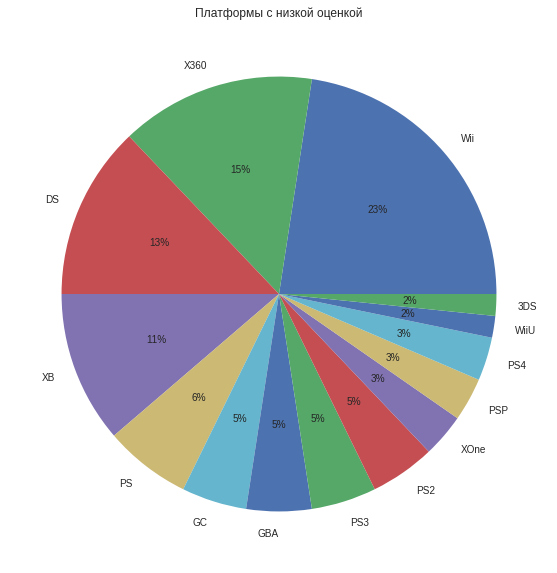

In [610]:
tmp.query('critic_score_group == "низкая оценка"').platform.value_counts().plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         legend=False,
         figsize=(10, 10),
         title='Платформы с низкой оценкой',
         )

name platform  year_of_release    genre  \
29    Call of Duty: Modern Warfare 3     X360             2011  Shooter   
37    Call of Duty: Modern Warfare 3      PS3             2011  Shooter   
60              Call of Duty: Ghosts     X360             2013  Shooter   
69              Call of Duty: Ghosts      PS3             2013  Shooter   
323             Call of Duty: Ghosts      PS4             2013  Shooter   
493             Call of Duty: Ghosts     XOne             2013  Shooter   
1040  Call of Duty: Modern Warfare 3       PC             2011  Shooter   
2500  Call of Duty: Modern Warfare 3      Wii             2011  Shooter   
5348            Call of Duty: Ghosts     WiiU             2013  Shooter   

      na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
29        9.04      4.24      0.13         1.32          88.0         3.4   
37        5.54      5.73      0.49         1.57          88.0         3.2   
60        6.73      2.56      0.04         0.91          73.0         2.6   
69        4.10      3.63      0.38         1.25          71.0         2.6   
323       1.78      1.43      0.05         0.57          78.0         3.7   
493       1.88      0.77      0.00         0.27          78.0         4.3   
1040      0.41      0.98      0.00         0.32          78.0         2.5   
2500      0.55      0.20      0.00         0.08          70.0         1.8   
5348      0.22      0.09      0.01         0.03          69.0         3.4   

     rating  summary_sales  ps   user_score_group critic_score_group  
29        M          15.92  no      низкая оценка  нормальная оценка  
37        M          14.41  PS      низкая оценка  нормальная оценка  
60        M          11.11  no      низкая оценка  нормальная оценка  
69        M          10.23  PS      низкая оценка  нормальная оценка  
323       M           4.35  PS      низкая оценка  нормальная оценка  
493       M           3.19  no  нормальная оценка  нормальная оценка  
1040      M           2.03  no      низкая оценка  нормальная оценка  
2500      M           0.91  no      низкая оценка  нормальная оценка  
5348      M           0.37  no      низкая оценка  нормальная оценка

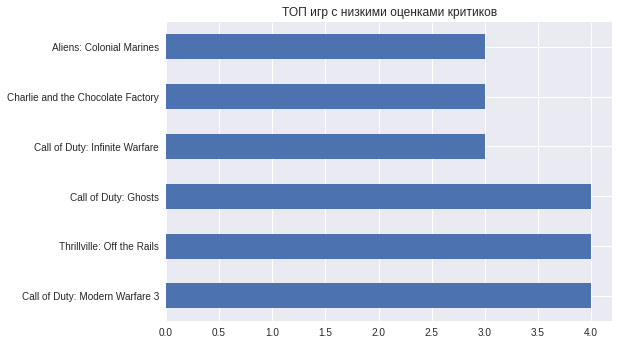

In [611]:
data = tmp.query('user_score_group == "низкая оценка"').name.value_counts()
data[data > 2].plot(kind='barh',
         title='ТОП игр с низкими оценками критиков',
         )

tmp.query('name in ["Call of Duty: Modern Warfare 3", "Call of Duty: Ghosts"]')

- Очень низких оценок критиков достаточно мало
- Больше всего низких оценок поставлено критиками играм на платформе Wii и X360
- Самая низко оцененная игра - Call of Duty (Modern Warfare 3, Ghosts). Причем и пользователи оценили их не высоко (до 5 баллов)

## Исследовательский анализ данных

### Исследование количества игр в разные годы

In [612]:
(df
 .query('year_of_release != -1')
 .pivot_table(index='year_of_release', values='na_sales', aggfunc='count')
 .sort_values('na_sales', ascending=False)
 .reset_index()
 .set_axis(['Год выпуска', 'Количество выпущенных игр'], axis=1)
)

Год выпуска  Количество выпущенных игр
0          2008                       1427
1          2009                       1426
2          2010                       1255
3          2007                       1197
4          2011                       1136
5          2006                       1006
6          2005                        939
7          2002                        829
8          2003                        775
9          2004                        762
10         2012                        653
11         2015                        606
12         2014                        581
13         2013                        544
14         2016                        502
15         2001                        482
16         1998                        379
17         2000                        350
18         1999                        338
19         1997                        289
20         1996                        263
21         1995                        219
22         1994                        121
23         1993                         62
24         1981                         46
25         1992                         43
26         1991                         41
27         1982                         36
28         1986                         21
29         1989                         17
30         1983                         17
31         1990                         16
32         1987                         16
33         1988                         15
34         1985                         14
35         1984                         14
36         1980                          9

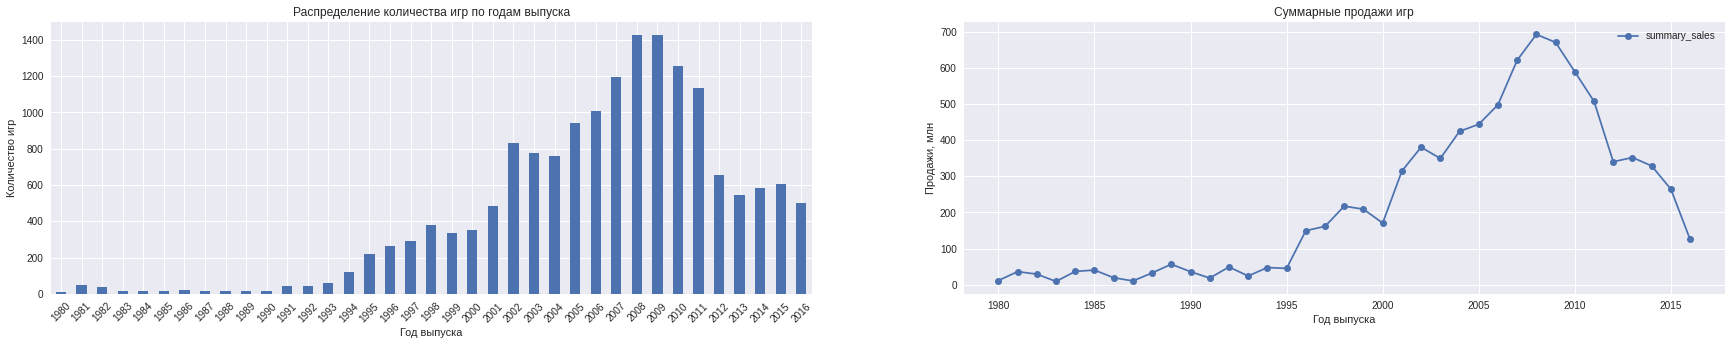

In [613]:
fig, ax = plt.subplots(1, 2, figsize=(30, 5))
data = (df
 .query('year_of_release != -1')
 .year_of_release.value_counts().
 sort_index())

(data 
 .plot(kind='bar', 
       ax=ax[0],
       title='Распределение количества игр по годам выпуска'))
ax[0].set_ylabel('Количество игр')
ax[0].set_xlabel('Год выпуска')
ax[0].set_xticklabels(data.index, rotation = 45)

(df.query('year_of_release != -1')
 .pivot_table(index=['year_of_release'], 
              values=['summary_sales'], 
              aggfunc='sum')
 .plot(title='Суммарные продажи игр', ax=ax[1], marker='o')
)
ax[1].set_xlabel('Год выпуска')
ax[1].set_ylabel('Продажи, млн')

plt.show()

- До 1991 года игр почти не было, как и их продаж. Поэтому период до 1991 года можно не рассматривать
- Далее популярность игр возрастала до небольшого спада в 1999-2000
- Затем резкий скачок - эпоха PlayStation1-2
- Самый большой пик популярности - 2008-2009 года
- Период примерно с 2011 по 2016 нам точно будет интересен, так как он актуальнее всего

### Распределени продаж по платформам

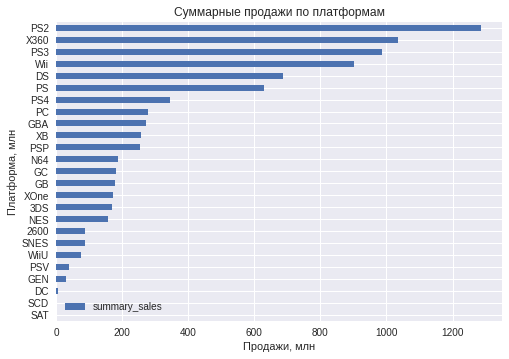

In [614]:
(df.query('year_of_release != -1')
 .pivot_table(index=['platform'], 
              values=['summary_sales'], 
              aggfunc='sum')
 .query('summary_sales > 0')
 .sort_values('summary_sales')
 .plot(kind='barh',
       title='Суммарные продажи по платформам'
      ))
plt.xlabel('Продажи, млн')
plt.ylabel('Платформа, млн')
plt.show()

In [615]:
def top_summary_sales_report(df):
    top_sales = (df.query('year_of_release != -1').pivot_table(
    index=['platform'], 
    values=['summary_sales', 'year_of_release'], 
    aggfunc={'summary_sales': 'sum', 'year_of_release': ['max', 'min']})
             .set_axis(['summary_sales','last_year_of_release', 'first_year_of_release'], axis=1)
             .sort_values('summary_sales', ascending=False)[:6]
            )
    top_sales['years_delta'] = top_sales.apply(lambda x: x['last_year_of_release'] - x['first_year_of_release'], axis=1)
    
    top_platforms = list(top_sales.index)
    top_platforms_ = np.array(top_platforms).reshape(2, 3)
    common_title = lambda x: f'Динамика суммарных продаж платформы {x}'
    
    fig, ax = plt.subplots(2, 3, figsize=(30, 10))
    columns_aliases = dict(zip(['summary_sales'], 
                      ['Суммарные продажи']))
    for i in range(2):
        for j in range(3):
            (df.query('year_of_release != -1 and platform == @top_platforms_[@i][@j]')
         .pivot_table(index=['year_of_release'], values=['summary_sales'], aggfunc='sum')
         .rename(columns=columns_aliases)
         .plot(marker='o', 
               ax=ax[i][j],
               title=common_title(top_platforms_[i][j]),
               legend=True,
              ))
            ax[i][j].set_xlabel('Год выпуска')
            ax[i][j].set_ylabel('Продажи, млн')
    return top_sales

Для изучения возьмем ТОП-6 по суммарным продажам, так как уже `PS4` существенно уступает по продажам `PS`

summary_sales  last_year_of_release  first_year_of_release  \
platform                                                               
PS2             1286.49                  2011                   2000   
X360            1033.82                  2016                   2005   
PS3              986.52                  2016                   2006   
Wii              900.61                  2016                   2006   
DS               686.80                  2013                   1985   
PS               628.49                  2003                   1994   

          years_delta  
platform               
PS2              11.0  
X360             11.0  
PS3              10.0  
Wii              10.0  
DS               28.0  
PS                9.0

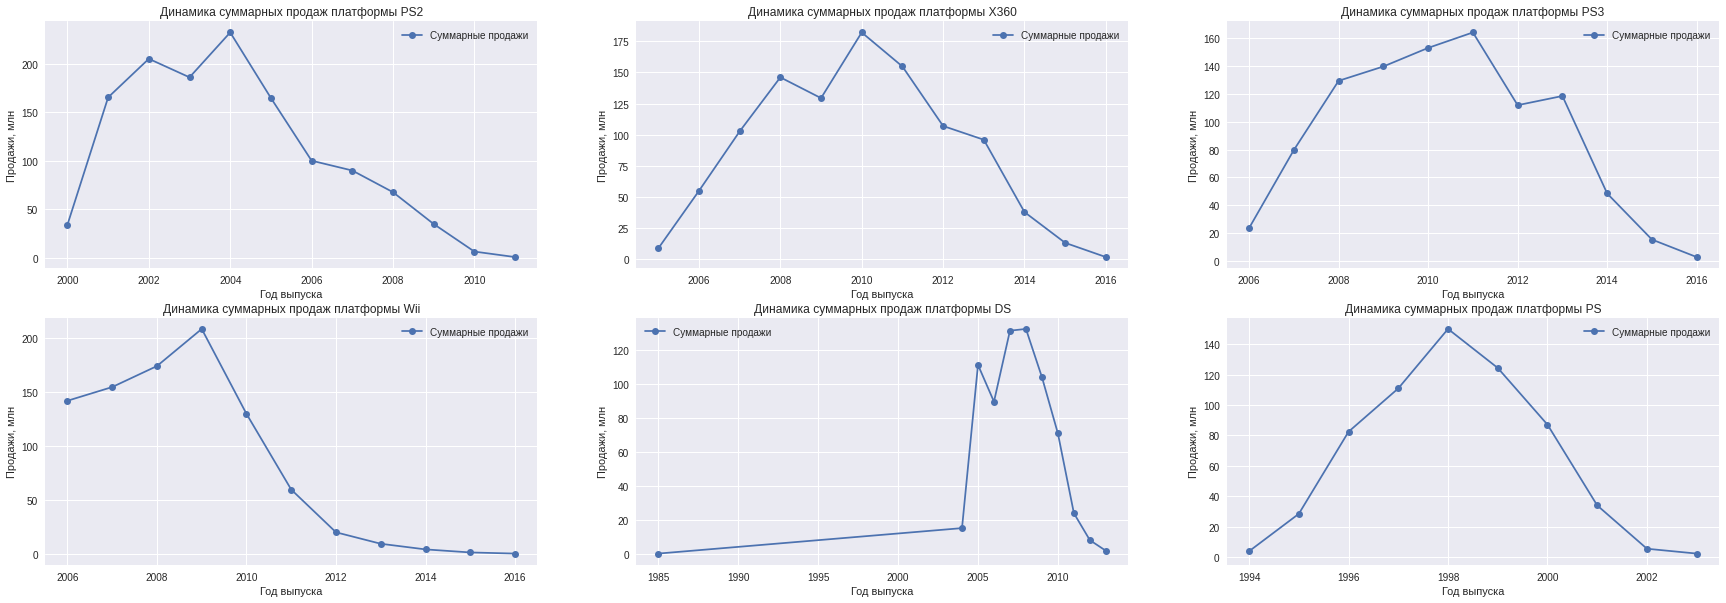

In [616]:
top_summary_sales_report(df)

Очень подозрительным кажется график для платформы DS в левой части (до 1990 года). Проверим его, так как это явно ошибка. Консоль вышла в 2004 году

In [617]:
df.query('year_of_release != -1 and year_of_release < 2000 and platform == "DS"')

name platform  year_of_release   genre  \
15957  Strongest Tokyo University Shogi DS       DS             1985  Action   

       na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
15957       0.0       0.0      0.02          0.0          -1.0        -1.0   

         rating  summary_sales  ps user_score_group  
15957  norating            0.0  no              NaN

Всего одна строчка, она точно никак не повлияет на общее распределение столбцов, однако улучшит форму распределения для платформы DS

In [618]:
df.drop(df.query('year_of_release != -1 and year_of_release < 2000 and platform == "DS"').index, inplace=True)

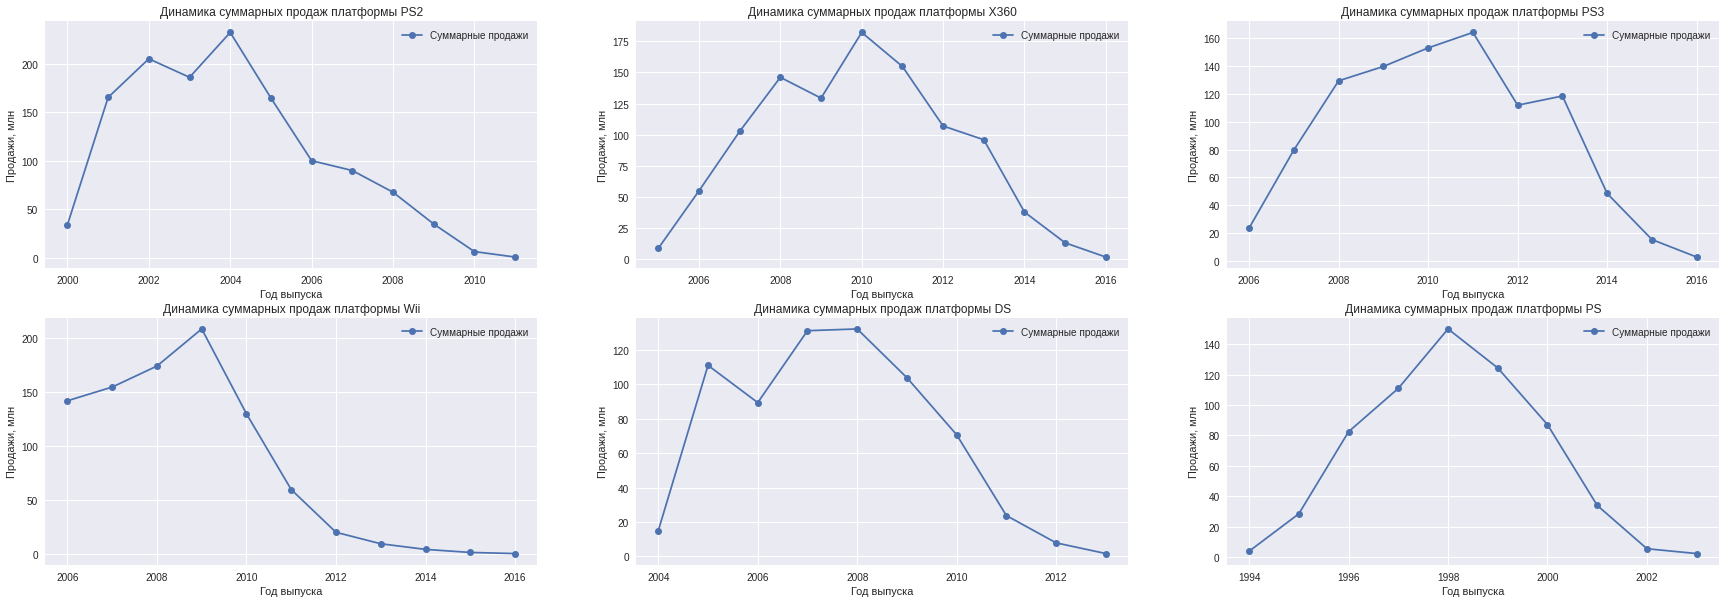

In [619]:
top_sales = top_summary_sales_report(df)

In [620]:
top_sales

summary_sales  last_year_of_release  first_year_of_release  \
platform                                                               
PS2             1286.49                  2011                   2000   
X360            1033.82                  2016                   2005   
PS3              986.52                  2016                   2006   
Wii              900.61                  2016                   2006   
DS               686.80                  2013                   2004   
PS               628.49                  2003                   1994   

          years_delta  
platform               
PS2              11.0  
X360             11.0  
PS3              10.0  
Wii              10.0  
DS                9.0  
PS                9.0

Итак, видим, что самые популярные платформы в большинстве своем похожи. 
- `DS`, `PS`, `PS3`, `X360`, `PS2` - в начале имеют довольны низкие продажи, далее переходят в пик продаж, к последнему году выпуска, представленному в датасете для этих платформ, суммарные продажи сильно снижаются.
- Разительно отличается платформа `Wii`, в самом раннем году выпуска, представленным в данных, продажи составили около 125 млн, что всего лишь на 50 млн меньше максимума, далее продажи игр для этой платформы плавно снижаются до около нулевых
- Можно видеть, что большинству платформ в ТОП-6 присущ десятилетний период между минимальными и максимальными продажами. Посчитаем так называемый характерный срок популярности службы платформы как среднее разности между последним годом выпуска игр для платформы и начальным

In [621]:
top_sales.years_delta.mean()

10.0

- Действительно, характерный срок, за который появляются и исчезают платформы, составляет 10 лет

Посмортим также динамику продаж по регионам

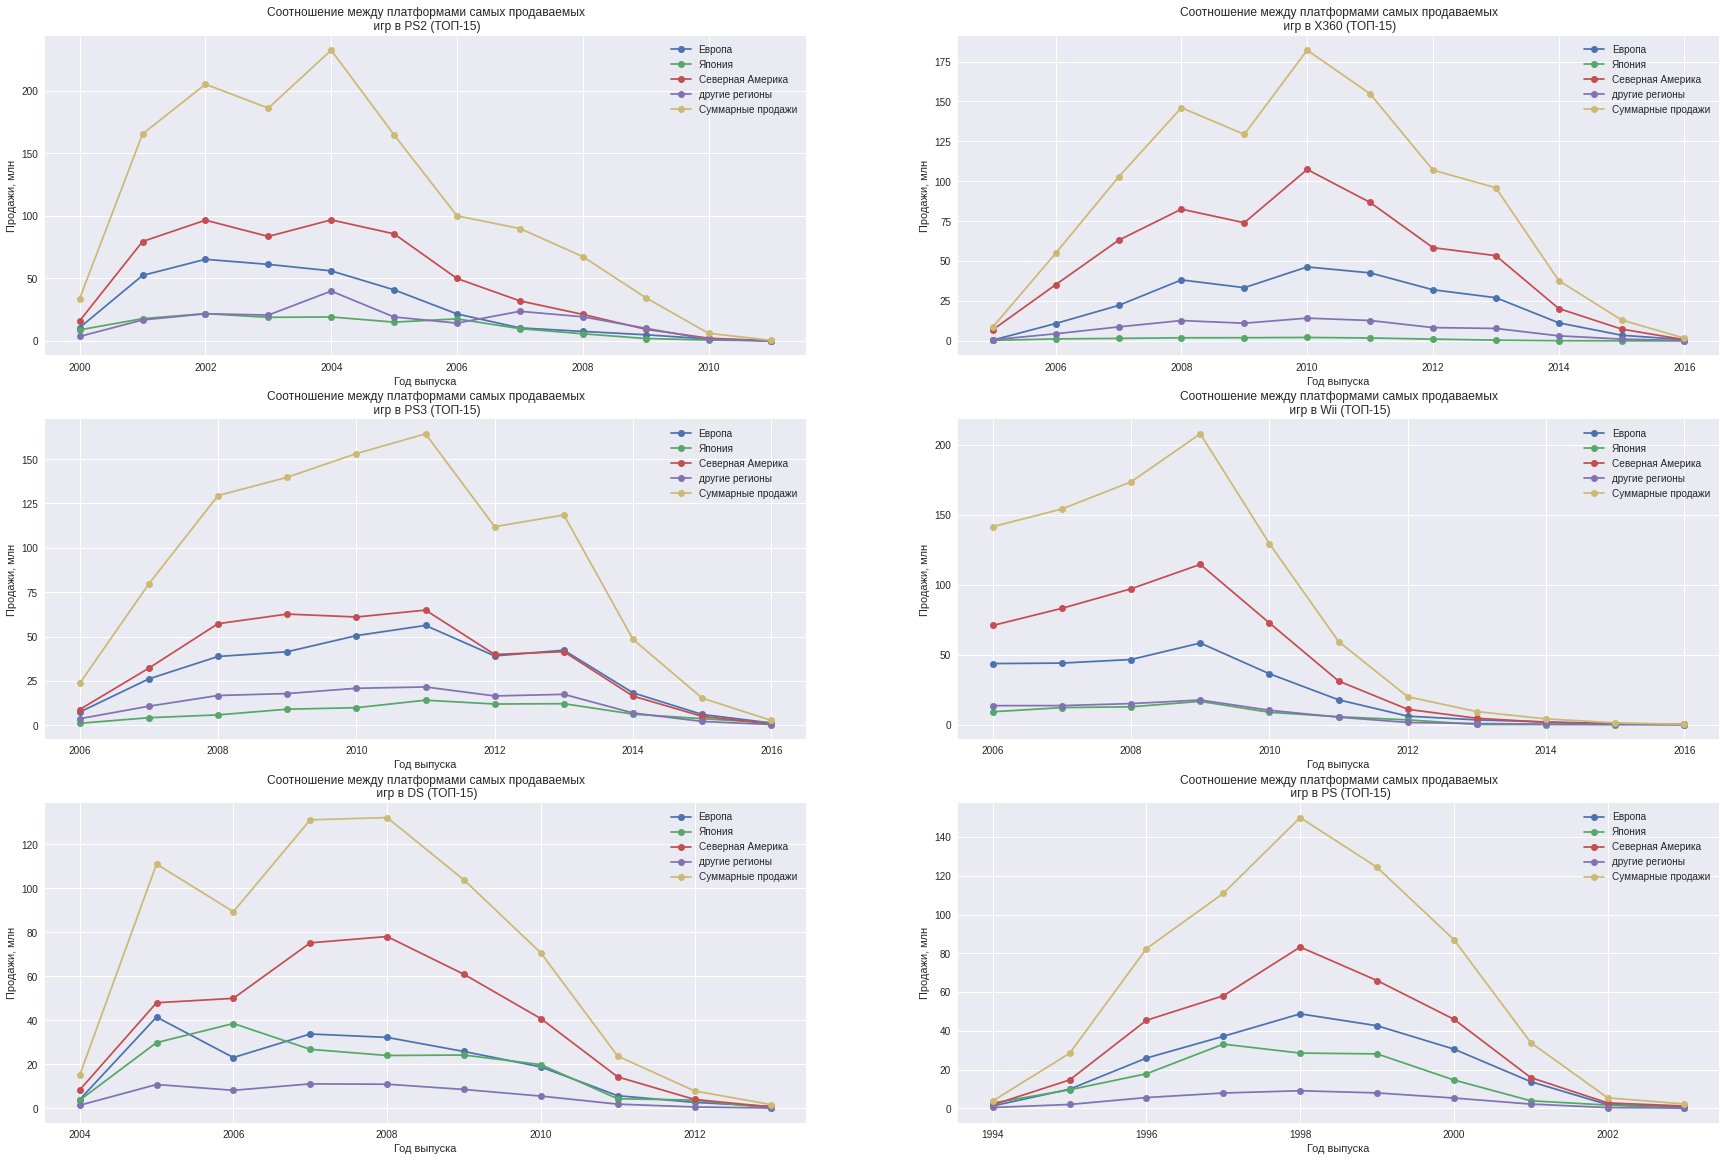

In [622]:
fig, ax = plt.subplots(3, 2, figsize=(30, 20))
top_platforms = list(top_sales.index)
top_platforms_ = np.array(top_platforms).reshape(3, 2)
columns_aliases = dict(zip(['summary_sales', 'na_sales', 'jp_sales', 'eu_sales', 'other_sales'], 
                      ['Суммарные продажи', 'Северная Америка', 'Япония', 'Европа', 'другие регионы'])) 

for i in range(3):
    for j in range(2):
        (df.query('year_of_release != -1 and platform == @top_platforms_[@i][@j]')
         .pivot_table(index=['year_of_release'], values=['summary_sales', 'na_sales', 'jp_sales', 'eu_sales', 'other_sales'], aggfunc='sum')
         .rename(columns=columns_aliases)
         .plot(marker='o', 
               ax=ax[i][j],
               title=common_title(top_platforms_[i][j]),
               legend=True,
              ))
        ax[i][j].set_xlabel('Год выпуска')
        ax[i][j].set_ylabel('Продажи, млн')

- Отметим, что максимальные продажи среди всех ТОП-6 платформ были реализованы в Северной Америке
- Второй место по суммарным продажам по всем ТОП-6 платформам занимает Европа
- Платформы `PS` и `DS` были более популярны в Японии, чем в других регионах

### Выбор актуального периода

Мир игр меняется очень быстро, в 1990-е игры от аркадных стали переходить к полноценным 3D вариантам. Жизенный цикл консоли как мы расчитали ранее, составляет около 10 лет. Если нам необходимы данные, которые помогут построить прогноз на 2017 год, нужны игры таких платформ, которые к 2016 году находятся на пике популярности или их продажи растут. То есть нужно отнять от 2017 года медианное значение жизненного цикла. Но для большей уверенности рассчитаем его по 10 самым популярным платформам. Причем будем вычислять левую часть жизненного цикла какждой платформы, под которую выпускаются игры в 21 веке, а затем найдем среди них медианное значение

In [623]:
platforms = list(df.query('year_of_release != -1 and year_of_release > 0').pivot_table(
    index=['platform'],
    values='summary_sales',
    aggfunc='sum'
).sort_values('summary_sales', ascending=False)[:10].index)

display(platforms)

piv = df.query('year_of_release != -1 and platform in @platforms').pivot_table(
    index=['platform', 'year_of_release'],
    values='summary_sales',
    aggfunc='sum'
).reset_index()

piv['max_sales_year'] = piv.groupby('platform')['summary_sales'].transform(
    lambda x: piv.loc[x.idxmax(), 'year_of_release']
)
piv = piv.pivot_table(index='platform', values=['year_of_release', 'max_sales_year'], aggfunc={'year_of_release': ['min', 'max'], 'max_sales_year': 'first'}).set_axis(['max', 'last', 'first'], axis=1)
piv['left_years_delta'] = piv.apply(lambda x: x['max'] - x['first'], axis=1)

print(f'Медианное значение левой части жизненного цикла (от первого года продаж под платформу до года с пиковыми продажами): {piv.left_years_delta.median()}')

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'PC', 'GBA', 'XB']

Медианное значение левой части жизненного цикла (от первого года продаж под платформу до года с пиковыми продажами): 4.0


Тогда актуальным будем считать период с 2012 по 2016 год

### Актуальные платформы

In [624]:
actual_df = df.query('year_of_release > 2011')

In [625]:
actual_platforms = actual_df.platform.unique()
actual_platforms

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

Построим для них графики суммарных продаж и скорости продаж

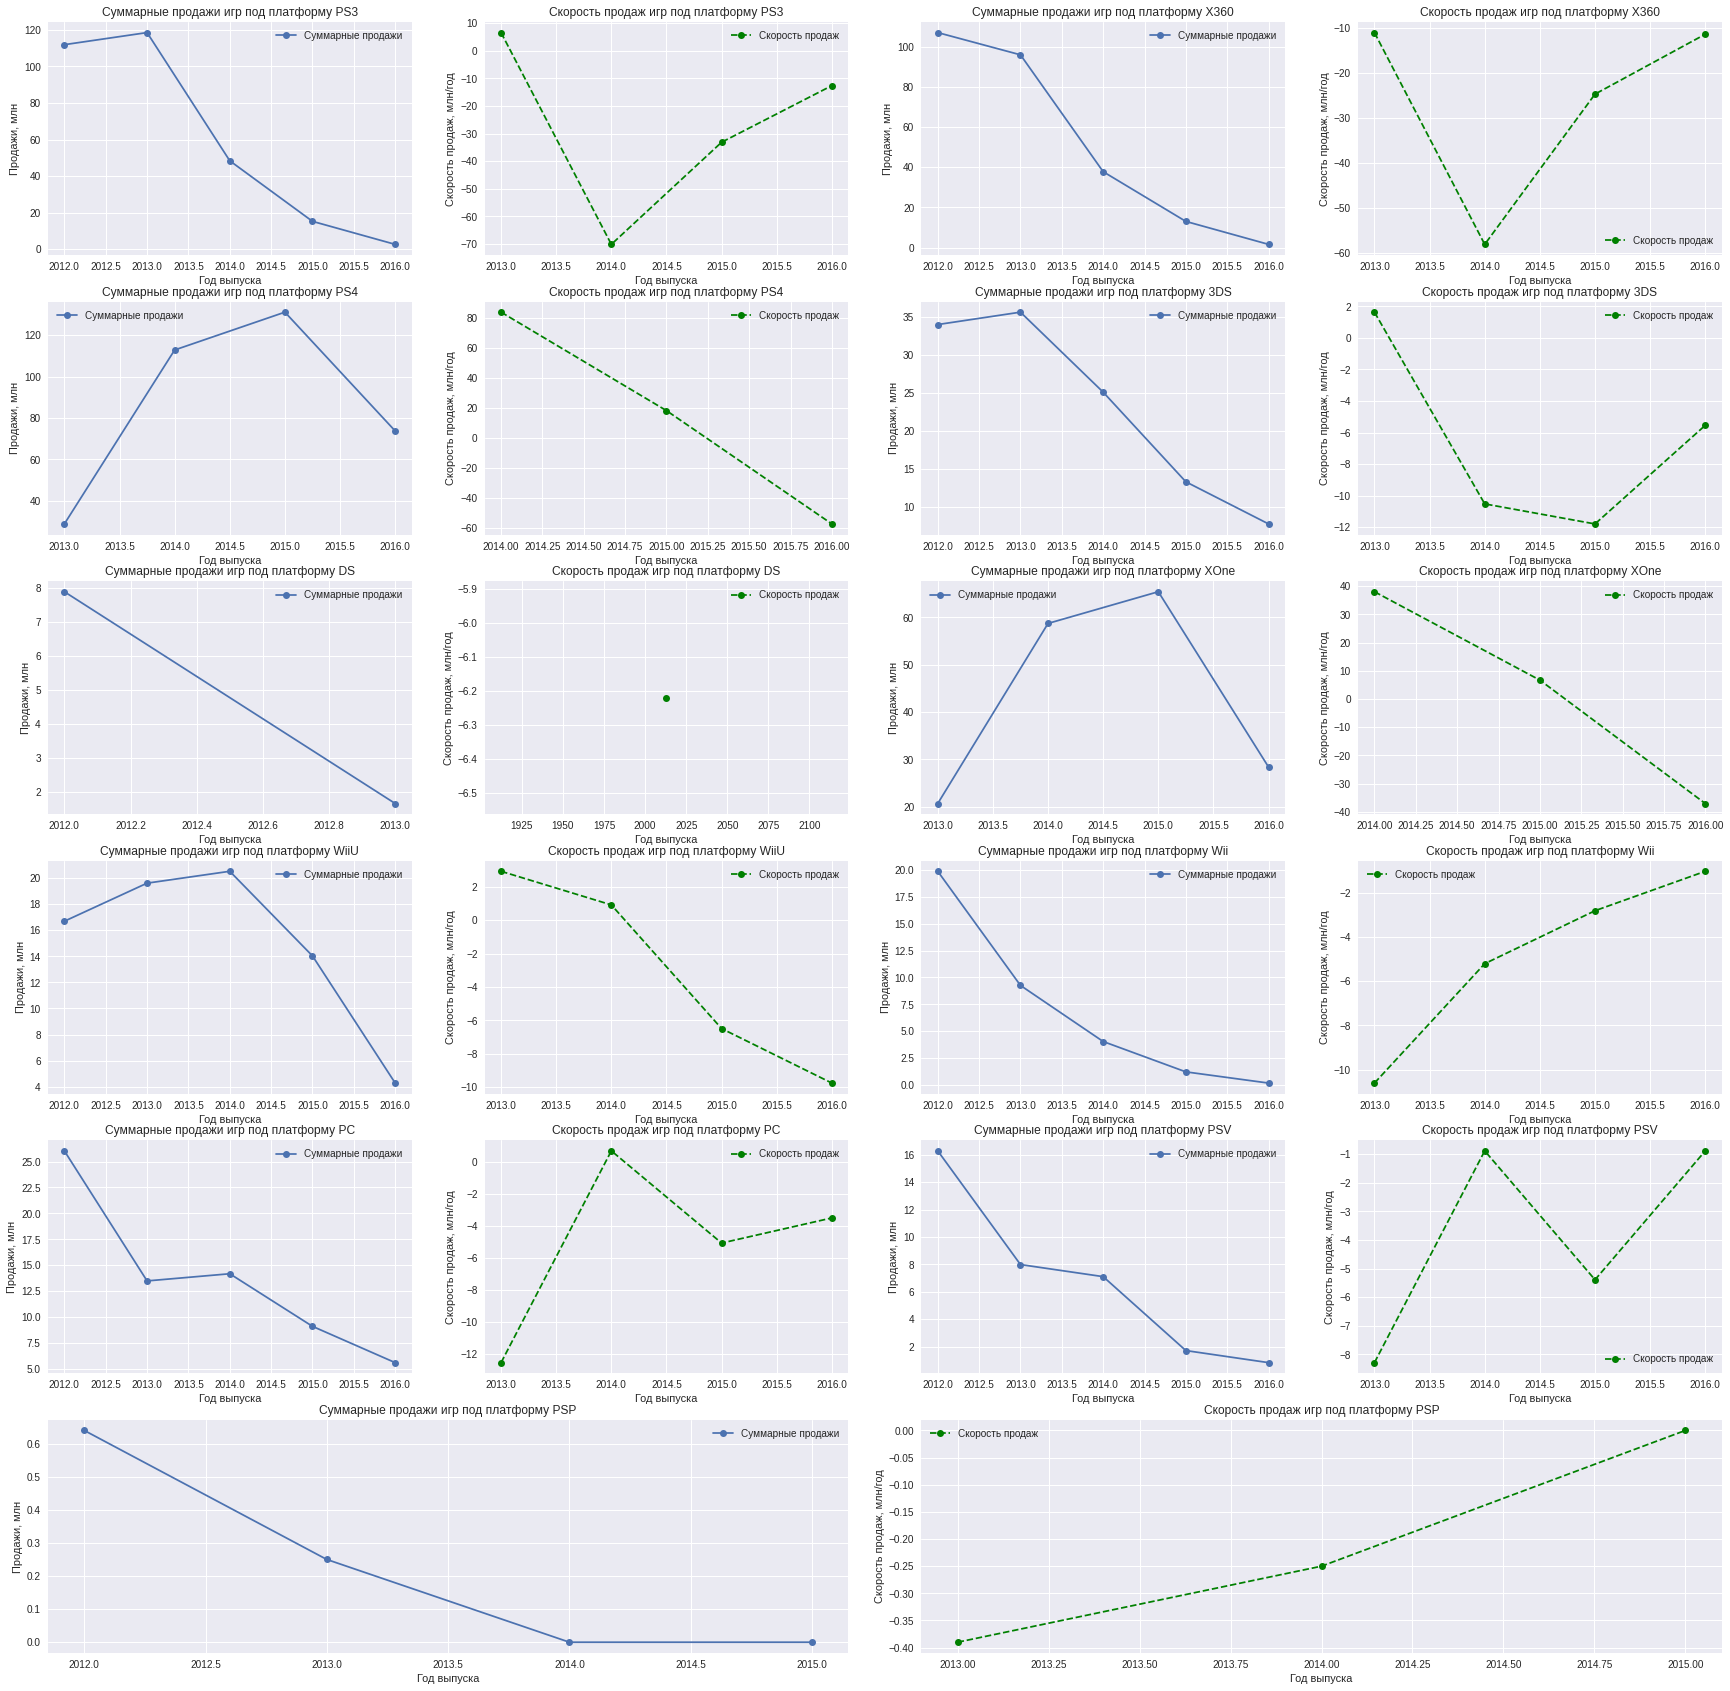

In [626]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(30, 30))
gs = GridSpec(6, 4, figure=fig) 
actual_platforms_10 = actual_platforms[:10].reshape(5, 2)
common_title_speed = lambda x: f'Скорость продаж игр под платформу {x}'
common_title_sales = lambda x: f'Суммарные продажи игр под платформу {x}'


for i in range(5):
    k = -1
    for j in range(2):
        ax_sales = fig.add_subplot(gs[i, k+1])
        ax_speed = fig.add_subplot(gs[i, k + 2])
        k = 1
        data = (actual_df.query('platform == @actual_platforms_10[@i][@j]')
         .pivot_table(index=['year_of_release'], values='summary_sales', aggfunc='sum'))
        
        (data
         .diff()
         .plot(marker='o', title=common_title_speed(actual_platforms_10[i][j]), ax=ax_speed, ls='--', color='green')
        )
        
        (data
         .plot(marker='o', title=common_title_sales(actual_platforms_10[i][j]), ax=ax_sales)
        )
        
        ax_sales.set_xlabel('Год выпуска')
        ax_speed.set_xlabel('Год выпуска')
        
        ax_sales.legend(['Суммарные продажи'])
        ax_speed.legend(['Скорость продаж'])

        ax_sales.set_ylabel('Продажи, млн')        
        ax_speed.set_ylabel('Скорость продаж, млн/год')
        
ax_speed = fig.add_subplot(gs[5, 2:])
ax_sales = fig.add_subplot(gs[5, :2])

data = (actual_df.query('platform == @actual_platforms[-1]')
     .pivot_table(index=['year_of_release'], values='summary_sales', aggfunc='sum'))

(data
     .diff()
     .plot(marker='o', title=common_title_speed(actual_platforms[-1]), ax=ax_speed,ls='--', color='green')
)

(data
     .plot(marker='o', title=common_title_sales(actual_platforms[-1]), ax=ax_sales)
)

ax_sales.set_xlabel('Год выпуска')
ax_speed.set_xlabel('Год выпуска')
        
ax_sales.legend(['Суммарные продажи'])
ax_speed.legend(['Скорость продаж'])

ax_sales.set_ylabel('Продажи, млн')        
ax_speed.set_ylabel('Скорость продаж, млн/год')
plt.show()

- Продажи игр под все платформы снижаются
- Некоторые графики скоростей выглядят очень резко, что может быть следствием частично пропущенных данных по платформе и году. 
- Такие платформы как Wii, PSP, X360, PS3, PSV имеют явную стагнацию продаж к 2015-2016 году, поэтому эти платформы уже неактуальны
- Платформы PS4 и XOne к 2016 году имеют весьма внушительные продажи, хотя и для них наблюдается стагнация
- Платформы WiiU, PC и 3DS к 2015-2016 году занимают определенную часть рынка, хотя и наблюдается сильная тенденция к снижению продаж

Будем считать наиболее перспективными и популярными платформами `PS4` и `XOne`, а также не будем сбрасывать со счетов платформы `WiiU`, `PC` и `3DS`

### Коробчатая диаграмма по продажам актуального периода

Построим коробчатую диаграмму по 5 самым актуальным платформам, причем будем выбирать их по суммарным продажам с 2015 года

In [627]:
top5_platform = (list(actual_df
                      .query('year_of_release > 2015')
                      .pivot_table(index='platform', 
                                   values='summary_sales', 
                                   aggfunc='sum')
                      .sort_values('summary_sales', 
                                   ascending=False).index[:5]))

top5_platform

['PS4', 'XOne', '3DS', 'PC', 'WiiU']

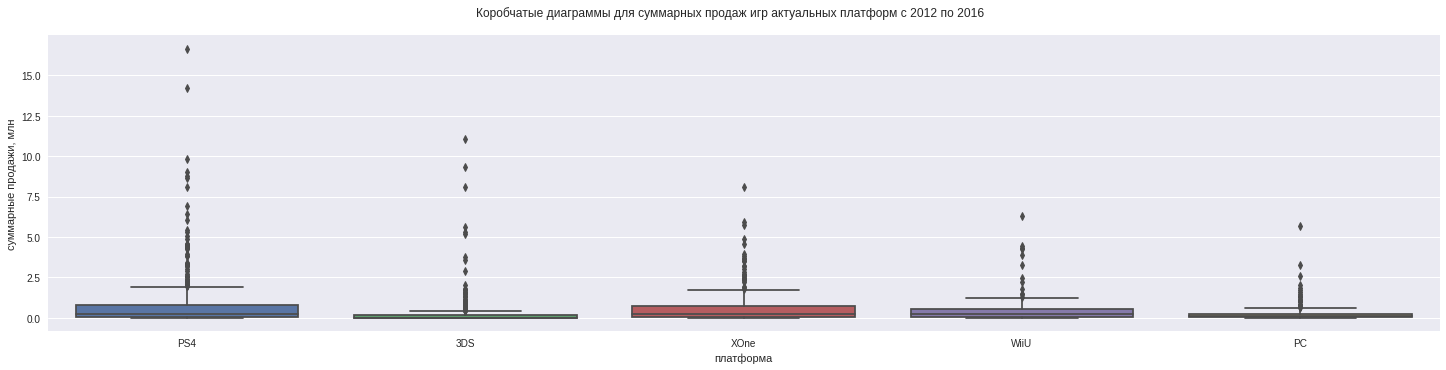

In [628]:
g = sns.catplot(
    data=actual_df.query('platform in @top5_platform'),
    x="platform",
    y="summary_sales",
    aspect=4,
    kind="box",
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Коробчатые диаграммы для суммарных продаж игр актуальных платформ с 2012 по 2016')
plt.xlabel('платформа')
plt.ylabel('суммарные продажи, млн')
plt.show()

In [629]:
piv = actual_df.query('platform in @top5_platform').pivot_table(index='platform', values='summary_sales', aggfunc={
    'summary_sales': ['median', ('q25', lambda x: x.quantile(.25)), ('q75', lambda x: x.quantile(.75)), 'mean']
}).sort_values('median').round(3)

piv['iqr'] = piv.apply(lambda x: x['q75'] - x['q25'], axis=1)
piv

mean  median   q25    q75    iqr
platform                                   
3DS       0.292    0.01  0.00  0.173  0.173
PC        0.274    0.09  0.03  0.260  0.230
PS4       0.884    0.21  0.04  0.802  0.762
WiiU      0.511    0.21  0.05  0.530  0.480
XOne      0.701    0.24  0.07  0.745  0.675

- Медианные продажи игр под все платформы не превышают 350000 экземпляров
- Виден очень большой выброс для платформы PS4. Популярность этой платформы была огромной, поэтому ничего удивительного в этом нет
- Аналогичные, но несколько меньшие выбросы наблюдаются для платформ 3DS и XOne. 
- XOne один из главных конкурентов PS4, именно эти платформы мы посчитали наиболее актуальными, поэтому к 2017 году прогноз по ним будет весьма полезен

### Влияние оценок пользователей и критиков на суммарные продажи популярных платформ

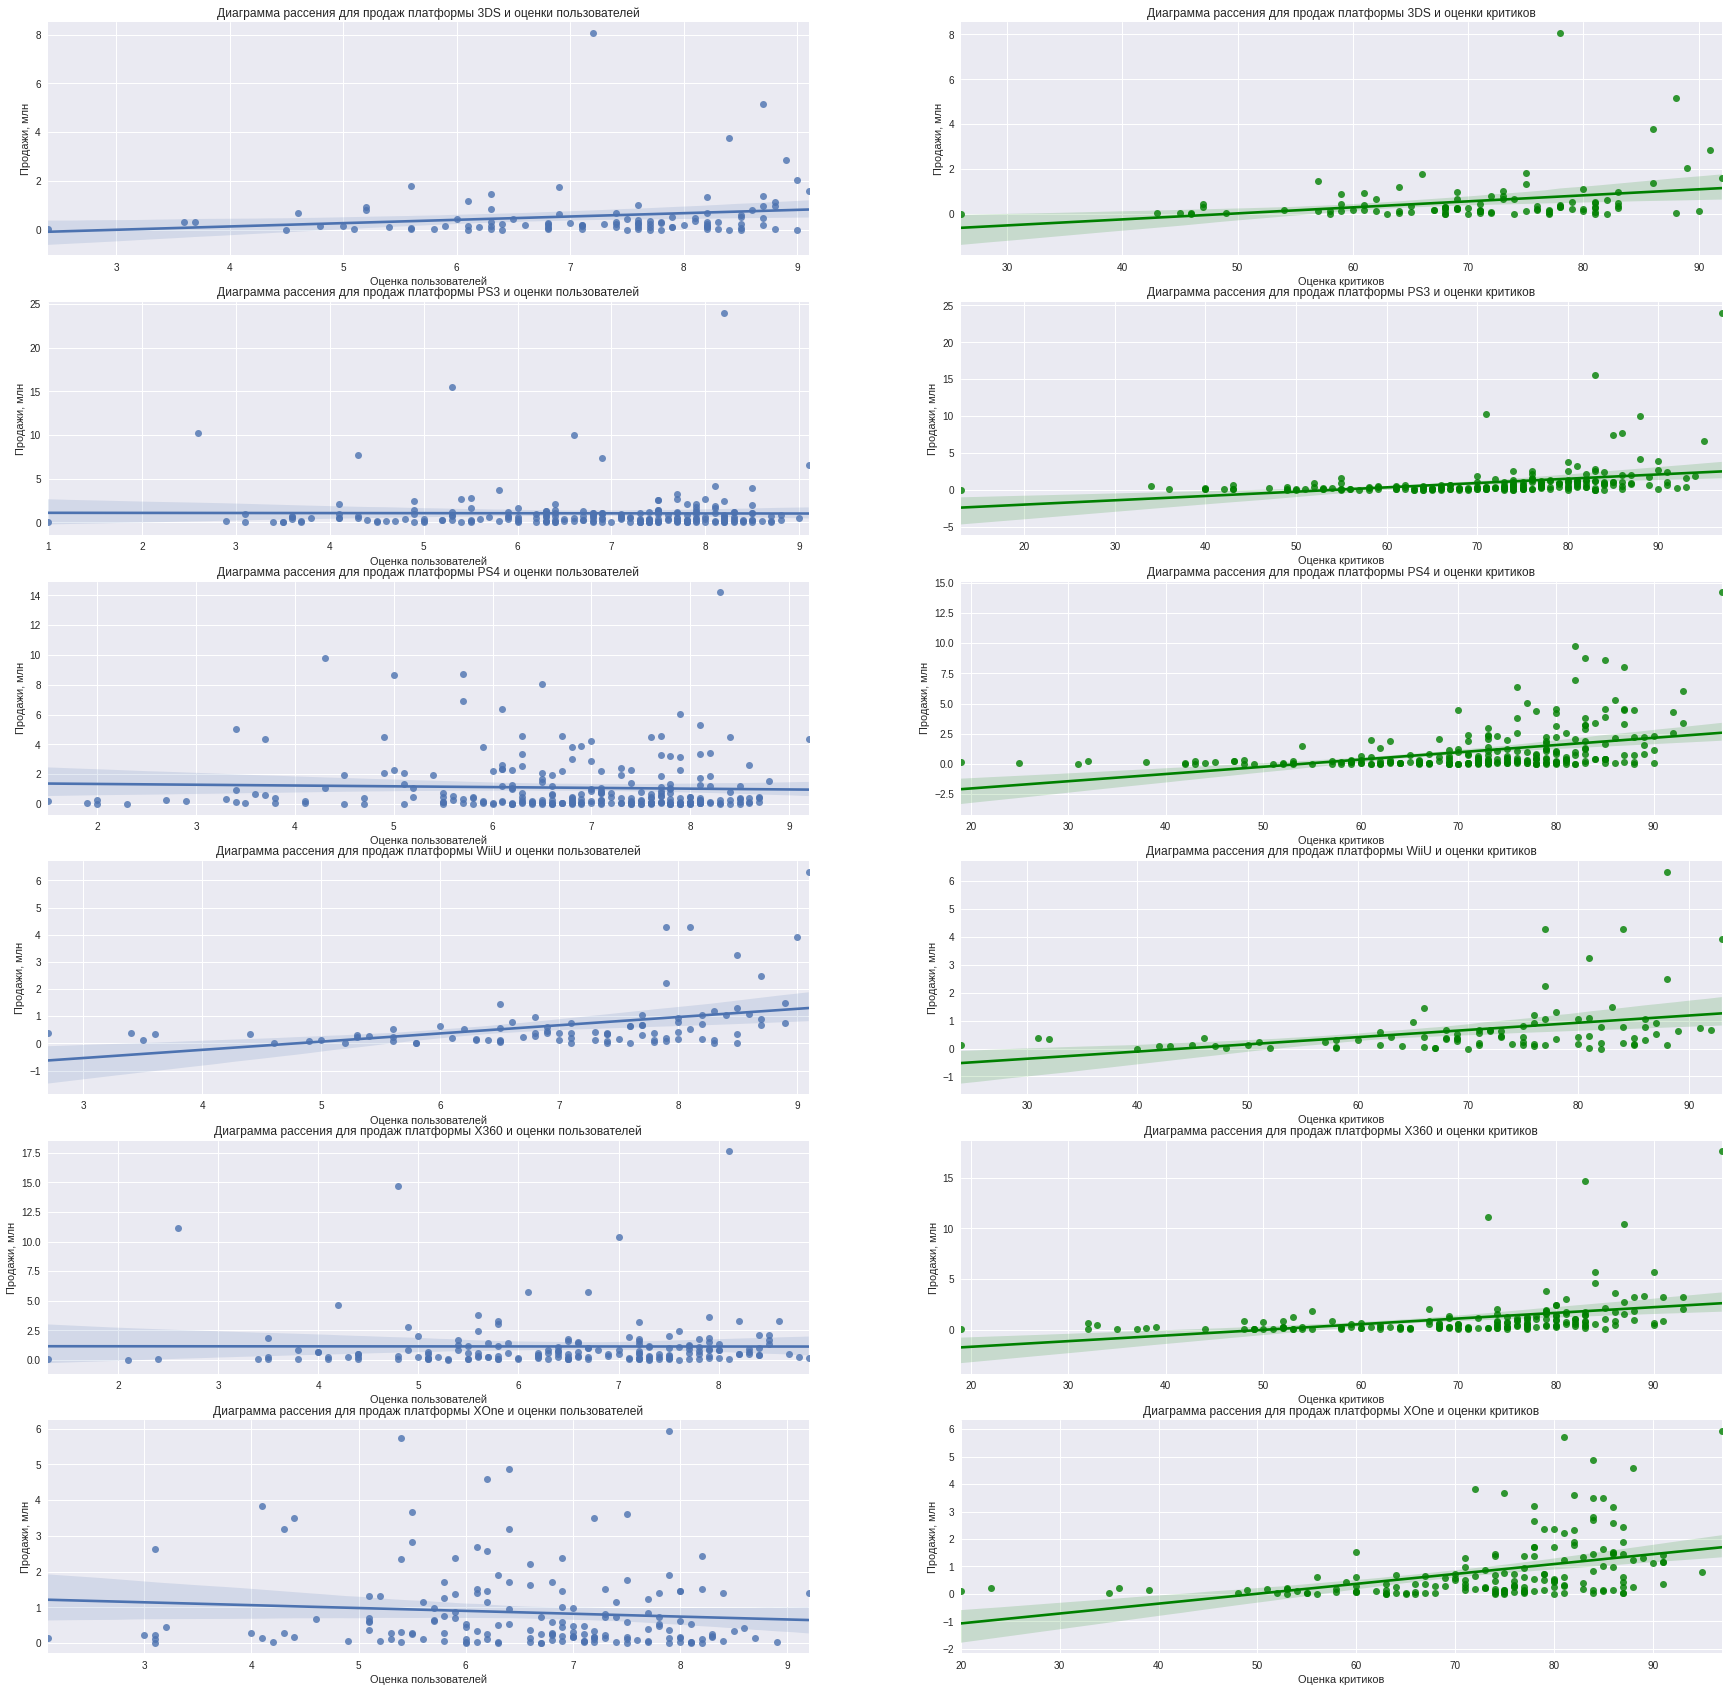

In [630]:
top6 = list(actual_df.pivot_table(index='platform', values='summary_sales', aggfunc='sum').sort_values('summary_sales', ascending=False)[:6].index)

fig, axes = plt.subplots(6, 2, figsize=(30, 30))

axes = axes.flatten()

for idx, (platform, vals) in enumerate(
    actual_df.query('platform in @top6 and user_score > -1 and critic_score > -1')
    .groupby('platform')[['user_score', 'critic_score', 'summary_sales']]
):
    sns.regplot(data=vals, x='user_score', y='summary_sales', ax=axes[2 * idx])
    axes[2 * idx].set_title(f"Диаграмма рассения для продаж платформы {platform} и оценки пользователей")
    axes[2 * idx].set_xlabel("Оценка пользователей")
    axes[2 * idx].set_ylabel("Продажи, млн")

    sns.regplot(data=vals, x='critic_score', y='summary_sales', ax=axes[2 * idx + 1], color='green')
    axes[2 * idx + 1].set_title(f"Диаграмма рассения для продаж платформы {platform} и оценки критиков")
    axes[2 * idx + 1].set_xlabel("Оценка критиков")
    axes[2 * idx + 1].set_ylabel("Продажи, млн")
    


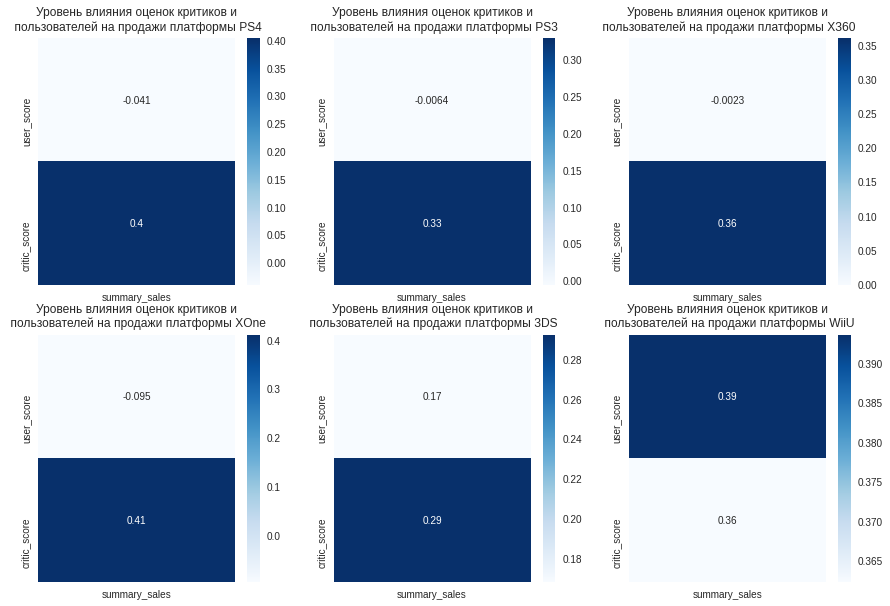

In [631]:
top6 = list(actual_df.pivot_table(index='platform', values='summary_sales', aggfunc='sum').sort_values('summary_sales', ascending=False)[:6].index)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes = axes.flatten()
for idx, pl in enumerate(top6):
    (sns.heatmap(actual_df.query('platform == @pl and user_score > -1 and critic_score > -1')[['user_score', 'critic_score', 'summary_sales']].corr()[['summary_sales']].query('summary_sales < 1'),
            annot=True,
            cmap="Blues",
            ax=axes[idx]
                )
    .set_title(f'Уровень влияния оценок критиков и\n пользователей на продажи платформы {pl}', y=1.01))
    # plt.show()

- Для почти всех популярных платформ большее справедливо, что большее влияние на продажи имеет оценка критиков. Причем разница между уровнем влияния весьма существенная. Для платформы WiiU наблюдается иная ситуация, во-первых оба коэффициента корреляции больше 0.35, во-вторых отзывы пользователей оказывают большее влияние на суммарные продажи
- При этом влияние оценки ограничено коэффициентом корреляции в 0.42
- Наибольшее влияние критическое мнение оказывает на продажи игр, выпущенных под платформу XOne, наименьшее - на игры под платформу 3DS

### Жанровое распределение игр актуального периода

In [632]:
piv = (actual_df
       .pivot_table(index='genre', 
                    values='summary_sales', 
                    aggfunc=['sum', 'count', 'median', 'mean'])
       .set_axis(['Общие продажи', 'Количество игр', 'Медианное значение продаж', 'Среднее значение продаж'], 
                 axis=1))
piv

Общие продажи  Количество игр  Медианное значение продаж  \
genre                                                                    
Action               439.46            1031                      0.070   
Adventure             24.00             302                      0.000   
Fighting              39.52             109                      0.100   
Misc                  79.85             192                      0.030   
Platform              57.95              85                      0.210   
Puzzle                 2.97              28                      0.020   
Racing                57.49             115                      0.160   
Role-Playing         142.19             370                      0.050   
Shooter              332.76             235                      0.480   
Simulation            26.90              80                      0.095   
Sports               195.50             268                      0.245   
Strategy              11.52              71                      0.020   

              Среднее значение продаж  
genre                                  
Action                       0.426246  
Adventure                    0.079470  
Fighting                     0.362569  
Misc                         0.415885  
Platform                     0.681765  
Puzzle                       0.106071  
Racing                       0.499913  
Role-Playing                 0.384297  
Shooter                      1.416000  
Simulation                   0.336250  
Sports                       0.729478  
Strategy                     0.162254

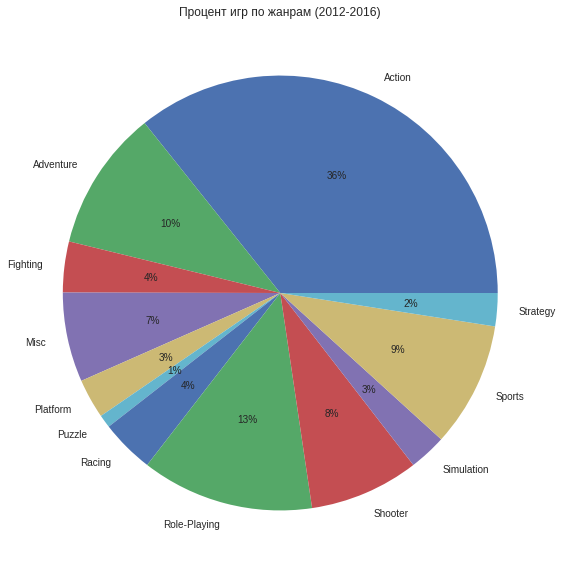

In [633]:
(piv
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='Количество игр',
         legend=False,
         title='Процент игр по жанрам (2012-2016)',
         figsize=(10, 10)
         ));plt.show()

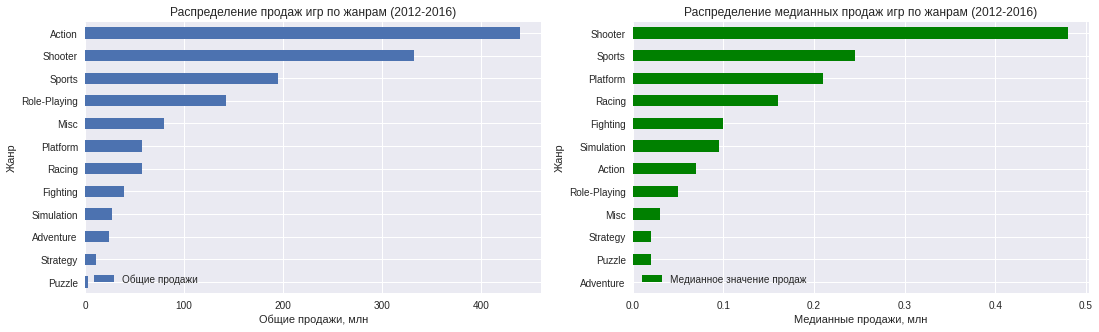

In [634]:
fig, ax = plt.subplots(1,2, figsize=(18, 5))

(piv
 .sort_values('Общие продажи')
 .plot(kind='barh',
       y='Общие продажи',
       title='Распределение продаж игр по жанрам (2012-2016)',
       ax=ax[0]
      )
)
ax[0].set_ylabel('Жанр')
ax[0].set_xlabel('Общие продажи, млн')


(piv
 .sort_values('Медианное значение продаж')
 .plot(kind='barh',
       y='Медианное значение продаж',
       title='Распределение медианных продаж игр по жанрам (2012-2016)',
       ax=ax[1],
       color='green'
      )
)
ax[1].set_ylabel('Жанр')
ax[1].set_xlabel('Медианные продажи, млн')

plt.show()

- Больше всего было продано игр в жанре Action
- Наименьшие суммарные продажи игр были осуществлены в жанре Puzzle


- Самые успешные жанры - Shooter, Sports. Несмотря на то, что наибольшие продажи получены по жанру Action, медианные продажи Shooter и Sports значительно превышает медианные продажи по жанру Action. Это вызвано разительно отличающимся количеством игр в жанре Action
- Наименее успешным жанром с 2012 по 2016 является Adventure, на втором месте Puzzle. Вновь та же причина, игр в жанре Adventure выпущено много, отсюда и высокие суммарные продажи, однако медианное значение продаж по жнару Puzzle существенно выше


- Больше всего игр с 2012 по 2016 год выпущено в жанре Action, на втором месте жанр - Role-Playing
- Меньше всего в этот период выпущено в жанре Puzzle и Strategy


То есть на 2017 год следует подумать о большем выпуске игр в жанре Shooter и Sports

## Портреты пользователей по регионам

In [635]:


def top5_regions(df, grouper, region: str):
    mappers = {
        'NA': {
            'column': 'na_sales',
            'for_title': 'Северной Америке'
        },
        'JP': {
            'column': 'jp_sales',
            'for_title': 'Японии'
        },
        'EU':{
            'column': 'eu_sales',
            'for_title': 'Европе'
        },
        'other':{
            'column': 'other_sales',
            'for_title': 'других регионах'
        },
        'platform': {
            'alias': 'платформ',
            'xlabel': 'Платформа'
        },
        'genre': {
            'alias': 'жанров' ,
            'xlabel': 'Жанр'
        },
        'rating': {
            'alias': 'рейтингов ESRB',
            'xlabel': 'рейтинг'
        }
        
        
    }
    if grouper == 'rating':
        df = df.query('rating != "norating"')
    piv = df.pivot_table(index=grouper, values=mappers[region]["column"], aggfunc='sum').sort_values(mappers[region]["column"], ascending=False)[:5]
    ax = piv.plot(kind='bar', title=f'TOP-5 самых популярных {mappers[grouper]["alias"]} в {mappers[region]["for_title"]}')
    plt.legend([f'Продажи в {mappers[region]["for_title"]}'])
    plt.ylabel('Продажи, млн')
    plt.xlabel(mappers[grouper]['xlabel'])
    plt.xticks(rotation=45)

    piv['part_sum'] = (piv.set_axis(['summary_sales'], axis=1) / df.pivot_table(index=grouper, values='summary_sales', aggfunc='sum')).dropna()
    piv['part_region'] = piv[mappers[region]["column"]] / df[mappers[region]["column"]].sum()
    top_pl = list(piv.index)
    tmp = df.query('platform not in @top_pl')
    piv.loc['others', [mappers[region]["column"], 'part_sum', 'part_region']] = [df[mappers[region]["column"]].sum() - piv[mappers[region]["column"]].sum(),
                                                                                    tmp[mappers[region]["column"]].sum() / tmp.summary_sales.sum(),
                                                                                    1 - piv.part_region.sum()]
    return piv.round(3)

### Северная Америка

#### TOP-5 платформ

In [636]:
df.pivot_table(index='platform', values='na_sales', aggfunc={'na_sales': ['sum', 'median']})

median     sum
platform                
2600       0.430   90.60
3DO        0.000    0.00
3DS        0.010   83.49
DC         0.000    5.43
DS         0.060  382.40
GB         0.000  114.32
GBA        0.100  187.54
GC         0.110  133.46
GEN        0.000   21.05
GG         0.000    0.00
N64        0.180  139.02
NES        0.405  125.94
NG         0.000    0.00
PC         0.000   94.53
PCFX       0.000    0.00
PS         0.080  336.52
PS2        0.090  583.84
PS3        0.120  393.49
PS4        0.060  108.74
PSP        0.000  109.17
PSV        0.000   12.58
SAT        0.000    0.72
SCD        0.000    1.00
SNES       0.000   61.23
TG16       0.000    0.00
WS         0.000    0.00
Wii        0.130  496.90
WiiU       0.110   38.10
X360       0.170  602.47
XB         0.110  186.69
XOne       0.120   93.12

na_sales  part_sum  part_region
platform                                 
X360        140.05     0.548        0.237
PS4         108.74     0.314        0.184
PS3         103.38     0.348        0.175
XOne         93.12     0.537        0.158
3DS          55.31     0.478        0.094
others       90.37     0.406        0.153

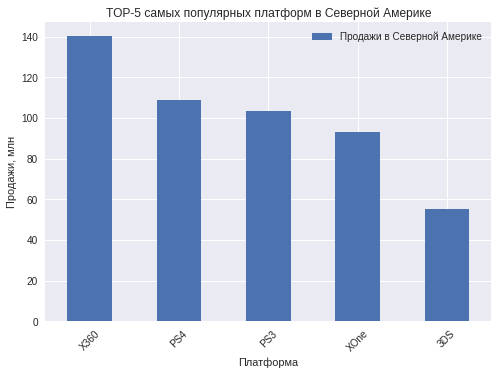

In [637]:
piv_pl_na = top5_regions(actual_df, 'platform', 'NA')
piv_pl_na

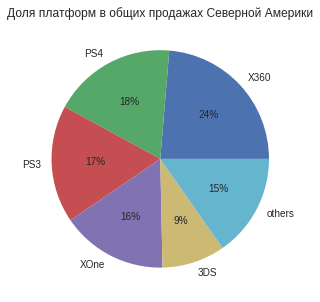

In [638]:
(piv_pl_na.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля платформ в общих продажах Северной Америки',
         figsize=(5, 5)
         ));plt.show()

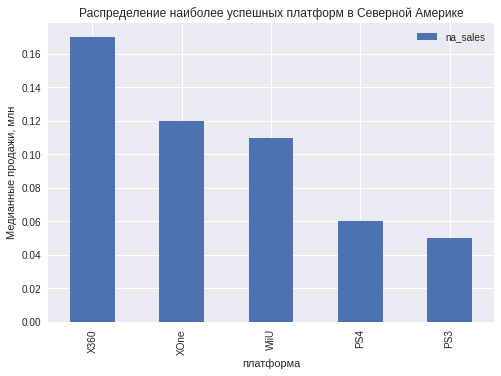

In [639]:
(actual_df
 .pivot_table(index='platform', values='na_sales', aggfunc='median')
 .sort_values('na_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных платформ в Северной Америке'))
plt.xlabel('платформа')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### ТОP-5 популярных жанров

na_sales  part_sum  part_region
genre                                        
Action          177.84     0.405        0.301
Shooter         144.77     0.435        0.245
Sports           81.53     0.417        0.138
Role-Playing     64.00     0.450        0.108
Misc             38.19     0.478        0.065
others           84.64     0.419        0.143

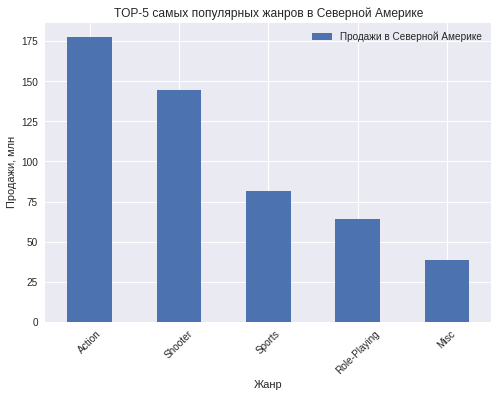

In [640]:
piv_genre_na = top5_regions(actual_df, 'genre', 'NA')
piv_genre_na

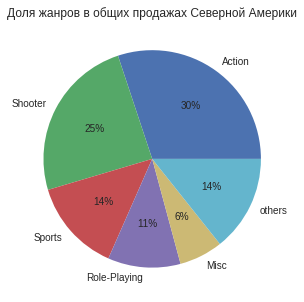

In [641]:
(piv_genre_na.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля жанров в общих продажах Северной Америки',
         figsize=(5, 5)
         ));plt.show()

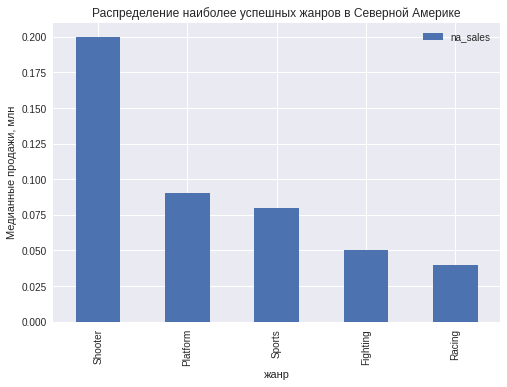

In [642]:
(actual_df
 .pivot_table(index='genre', values='na_sales', aggfunc='median')
 .sort_values('na_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных жанров в Северной Америке'))
plt.xlabel('жанр')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### Влияние рейтинга ESRB

na_sales  part_sum  part_region
rating                                 
M         231.57     0.419        0.475
E         114.37     0.394        0.235
E10+       75.70     0.463        0.155
T          66.02     0.426        0.135
others     -0.00     0.420       -0.000

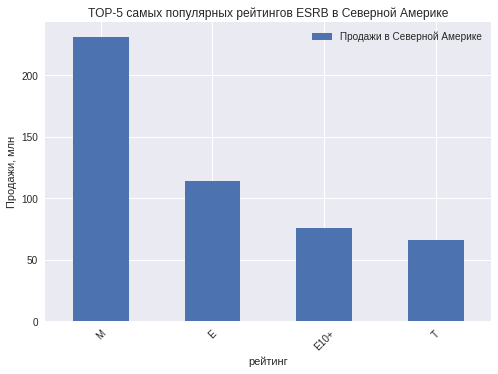

In [643]:
piv_rating_na = top5_regions(actual_df, 'rating', 'NA')
piv_rating_na

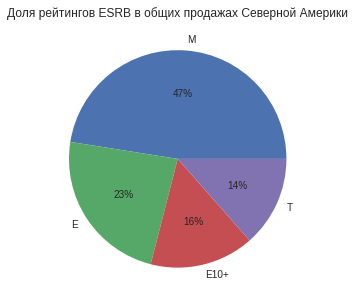

In [644]:
(piv_rating_na.query('part_region > 0').plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля рейтингов ESRB в общих продажах Северной Америки',
         figsize=(5, 5)
         ));plt.show()

- Самая популярная платформа в Северной Америке - `X360`, продажи игр под нее составляют около 24% от всех продаж Северной Америке. Кроме того, продажи под данную платформу составляют почти 60% мировых продаж в период с 2012 по 2016 год
- Самыми популярными жанрами игр являются `Aсtion` и `Shooter`, продажи с них составляют 40% и 44% мировых продаж и 30% и 24.5% процентов от американский продаж
- Наиболее популярны игры с рейтингом `M` (для взрослых) и `E` (для всех), они составляют 41% и почти 40% мировых продаж, а также 47.5% и 23.5% от американских продаж


- Самая успешная платформа - `X360` - совпадает с самой популярной
- Самый успешный жанр игр - `Shooter`


### Европа

#### TOP-5 платформ

eu_sales  part_sum  part_region
platform                                 
PS4         141.09     0.407        0.278
PS3         106.86     0.360        0.211
X360         74.52     0.292        0.147
XOne         51.59     0.298        0.102
3DS          42.64     0.369        0.084
others       90.12     0.405        0.178

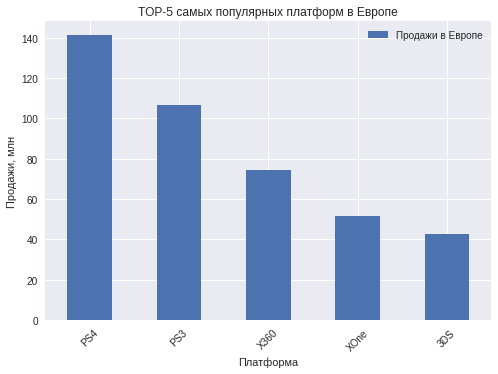

In [645]:
piv_pl_eu = top5_regions(actual_df, 'platform', 'EU')
piv_pl_eu

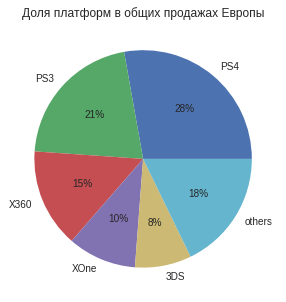

In [646]:
(piv_pl_eu.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля платформ в общих продажах Европы',
         figsize=(5, 5)
         ));plt.show()

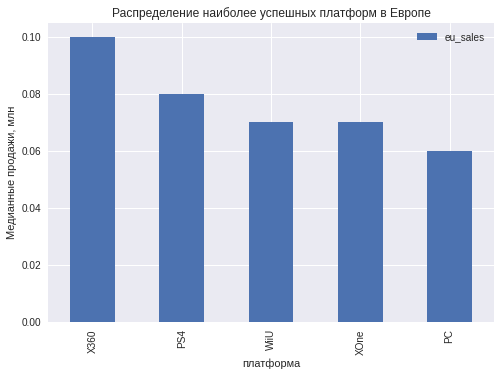

In [647]:
(actual_df
 .pivot_table(index='platform', values='eu_sales', aggfunc='median')
 .sort_values('eu_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных платформ в Европе'))
plt.xlabel('платформа')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### ТОP-5 популярных жанров

eu_sales  part_sum  part_region
genre                                        
Action          159.34     0.363        0.314
Shooter         113.47     0.341        0.224
Sports           69.09     0.353        0.136
Role-Playing     48.53     0.341        0.096
Racing           27.29     0.475        0.054
others           89.10     0.359        0.176

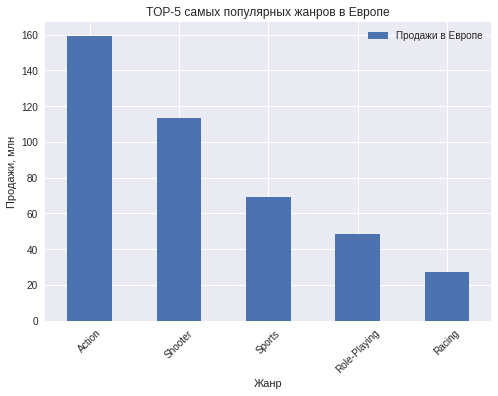

In [648]:
piv_genre_eu = top5_regions(actual_df, 'genre', 'EU')
piv_genre_eu

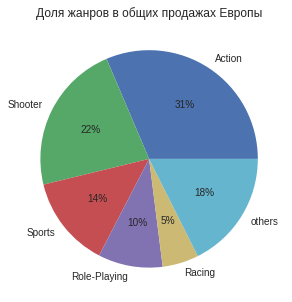

In [649]:
(piv_genre_eu.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля жанров в общих продажах Европы',
         figsize=(5, 5)
         ));plt.show()

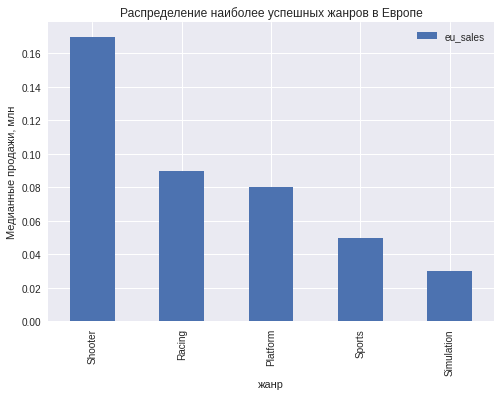

In [650]:
ax = (actual_df
 .pivot_table(index='genre', values='eu_sales', aggfunc='median')
 .sort_values('eu_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных жанров в Европе'))
plt.xlabel('жанр')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### Влияние рейтинга ESRB

eu_sales  part_sum  part_region
rating                                 
M         193.96     0.351        0.467
E         113.03     0.389        0.272
E10+       55.37     0.339        0.133
T          52.96     0.342        0.128
others     -0.00     0.358       -0.000

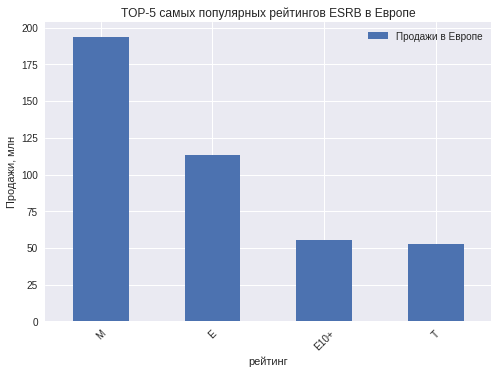

In [651]:
piv_rating_eu = top5_regions(actual_df, 'rating', 'EU')
piv_rating_eu

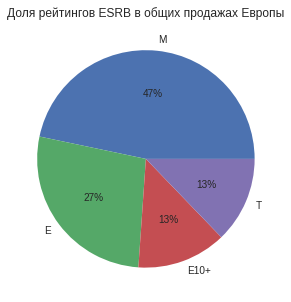

In [652]:
(piv_rating_eu.query('part_region > 0').plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля рейтингов ESRB в общих продажах Европы',
         figsize=(5, 5)
         ));plt.show()

- Самая популярная платформа в Европе - `PS4`, продажи игр под нее составляют около 28% от всех продаж Европы. Кроме того, продажи под данную платформу составляют около 41% мировых продаж в период с 2012 по 2016 год
- Самыми популярными жанрами игр являются `Aсtion` и `Shooter`, продажи с них составляют 36% и 34% мировых продаж и 31% и 22.5% процентов от европейских продаж
- Наиболее популярны игры с рейтингом `M` (для взрослых) и `E` (для всех), они составляют 35% и почти 39% мировых продаж, а также около 47% и 27.2% от европейских продаж


- Самая успешная платформа - `X360` - не совпадает с самой популярной
- Самый успешный жанр игр - `Shooter`

### Япония

#### TOP-5 платформ

jp_sales  part_sum  part_region
platform                                 
3DS          87.79     0.759        0.456
PS3          35.29     0.119        0.183
PSV          21.04     0.620        0.109
PS4          15.96     0.046        0.083
WiiU         13.01     0.173        0.068
others       19.49     0.036        0.101

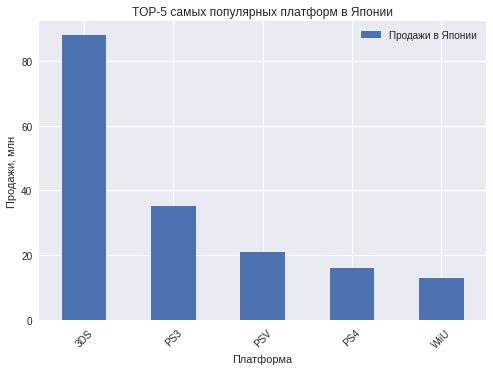

In [653]:
piv_pl_jp = top5_regions(actual_df, 'platform', 'JP')
piv_pl_jp

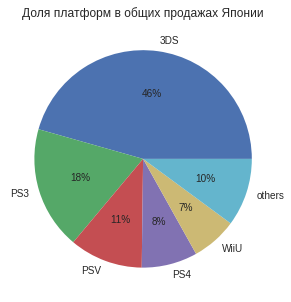

In [654]:
(piv_pl_jp.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля платформ в общих продажах Японии',
         figsize=(5, 5)
         ));plt.show()

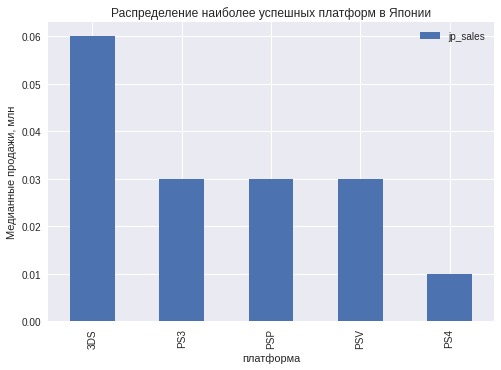

In [655]:
ax = (actual_df
 .pivot_table(index='platform', values='jp_sales', aggfunc='median')
 .sort_values('jp_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных платформ в Японии'))
plt.xlabel('платформа')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### ТОP-5 популярных жанров

jp_sales  part_sum  part_region
genre                                        
Role-Playing     65.44     0.460        0.340
Action           52.80     0.120        0.274
Misc             12.86     0.161        0.067
Simulation       10.41     0.387        0.054
Fighting          9.44     0.239        0.049
others           41.63     0.137        0.216

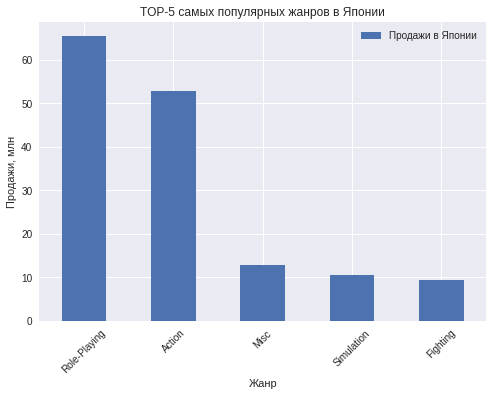

In [656]:
piv_genre_jp = top5_regions(actual_df, 'genre', 'JP')
piv_genre_jp

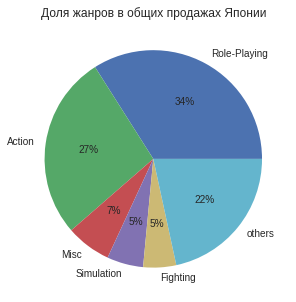

In [657]:
(piv_genre_jp.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля жанров в общих продажах Японии',
         figsize=(5, 5)
         ));plt.show()

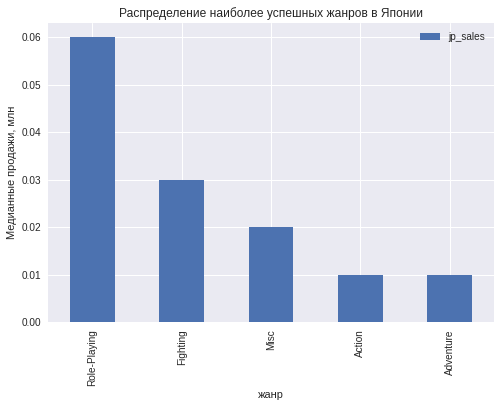

In [658]:
ax = (actual_df
 .pivot_table(index='genre', values='jp_sales', aggfunc='median')
 .sort_values('jp_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных жанров в Японии'))
plt.xlabel('жанр')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### Влияние рейтинга ESRB

jp_sales  part_sum  part_region
rating                                 
E          28.33     0.098        0.338
T          26.02     0.168        0.311
M          21.20     0.038        0.253
E10+        8.19     0.050        0.098
others     -0.00     0.072       -0.000

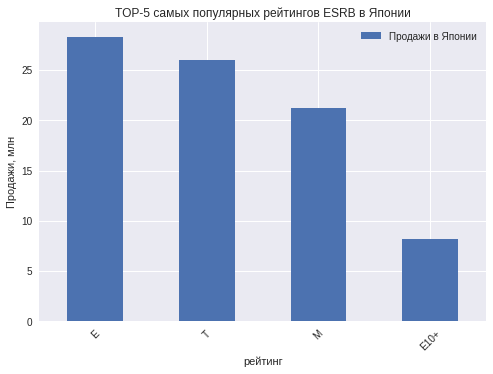

In [659]:
piv_rating_jp = top5_regions(actual_df, 'rating', 'JP')
piv_rating_jp

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


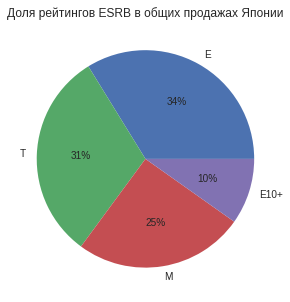

In [660]:
(piv_rating_jp.query('part_region > 0').plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля рейтингов ESRB в общих продажах Японии',
         figsize=(5, 5)
         ));plt.show()

- Самая популярная платформа в Японии - `3DS`, продажи игр под нее составляют около 46% от всех продаж Японии. Кроме того, продажи под данную платформу составляют около 76% мировых продаж в период с 2012 по 2016 год
- Самыми популярными жанрами игр являются `Role playing` и `Action`, продажи с них составляют 46% и 12% мировых продаж и 34% и 27.4% процентов от японских продаж
- Наиболее популярны игры с рейтингом `E` (для всех) и `T` (подросткам), они составляют 10% и почти 17% мировых продаж, а также около 34% и 31% от японских продаж


- Самая успешная платформа - `3DS` - совпадает с самой популярной
- Самый успешный жанр игр - `Role-playing`

### Другие регионы

#### TOP-5 платформ

other_sales  part_sum  part_region
platform                                    
PS4             48.35     0.140        0.310
PS3             43.26     0.146        0.277
X360            20.40     0.080        0.131
XOne            14.27     0.082        0.091
3DS              8.87     0.077        0.057
others          21.01     0.094        0.135

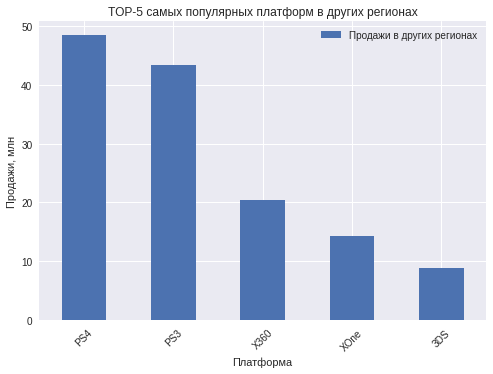

In [661]:
piv_pl_other = top5_regions(actual_df, 'platform', 'other')
piv_pl_other

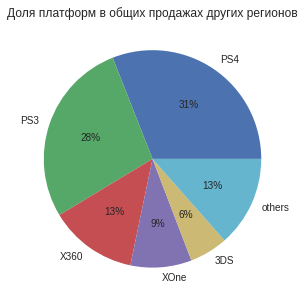

In [662]:
(piv_pl_other.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля платформ в общих продажах других регионов',
         figsize=(5, 5)
         ));plt.show()

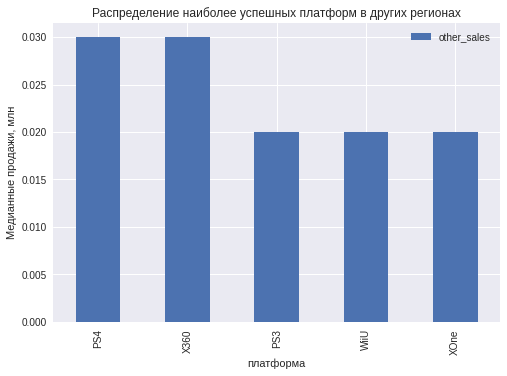

In [663]:
ax = (actual_df
 .pivot_table(index='platform', values='other_sales', aggfunc='median')
 .sort_values('other_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных платформ в других регионах'))
plt.xlabel('платформа')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### ТОP-5 популярных жанров

other_sales  part_sum  part_region
genre                                           
Action              51.14     0.116        0.327
Shooter             37.26     0.112        0.239
Sports              22.44     0.115        0.144
Role-Playing        14.83     0.104        0.095
Misc                 7.67     0.096        0.049
others              22.82     0.111        0.146

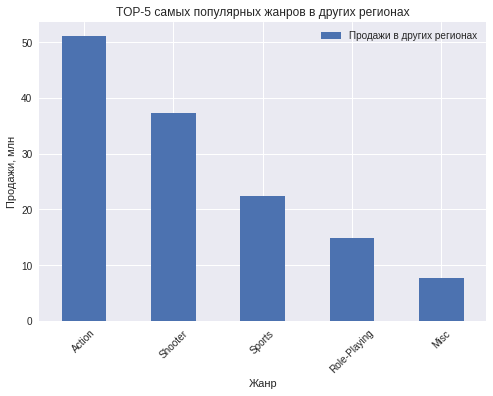

In [664]:
piv_genre_other = top5_regions(actual_df, 'genre', 'other')
piv_genre_other

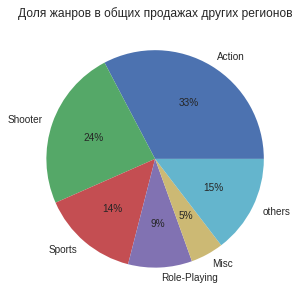

In [665]:
(piv_genre_other.plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля жанров в общих продажах других регионов',
         figsize=(5, 5)
         ));plt.show()

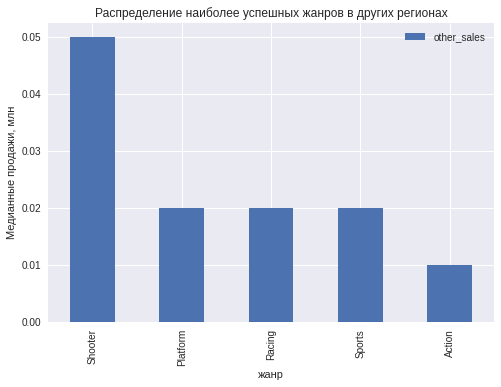

In [666]:
ax = (actual_df
 .pivot_table(index='genre', values='other_sales', aggfunc='median')
 .sort_values('other_sales', ascending=False)[:5]
 .plot(kind='bar', title='Распределение наиболее успешных жанров в других регионах'))
plt.xlabel('жанр')
plt.ylabel('Медианные продажи, млн')
plt.show()

#### Влияние рейтинга ESRB

other_sales  part_sum  part_region
rating                                    
M             63.38     0.115        0.491
E             31.44     0.108        0.244
T             17.94     0.116        0.139
E10+          16.23     0.099        0.126
others        -0.00     0.111       -0.000

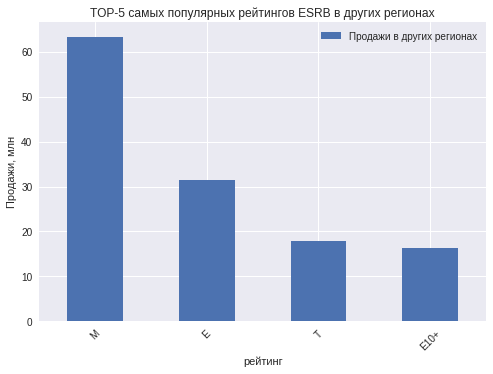

In [667]:
piv_rating_other = top5_regions(actual_df, 'rating', 'other')
piv_rating_other

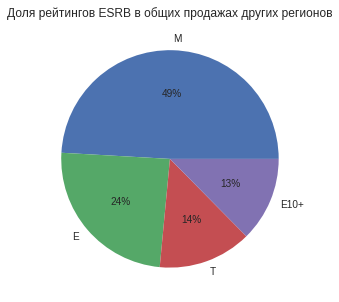

In [668]:
(piv_rating_other.query('part_region > 0').plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         y='part_region',
         legend=False,
         title='Доля рейтингов ESRB в общих продажах других регионов',
         figsize=(5, 5)
         ));plt.show()

- Самая популярная платформа в других регионах - `PS4`, продажи игр под нее составляют около 31% от всех продаж других регионов. Кроме того, продажи под данную платформу составляют около 14% мировых продаж в период с 2012 по 2016 год
- Самыми популярными жанрами игр являются `Action` и `Shooter`, продажи с них составляют 12% и 11% мировых продаж и 33% и 24% процентов от внутренних продаж
- Наиболее популярны игры с рейтингом `M` (для взрослых) и `E` (для всех), они составляют 11.5% и почти 11% мировых продаж, а также около 50% и 24.4% от внутренних продаж


- Самая успешная платформа - `PS4` - совпадает с самой популярной
- Самый успешный жанр игр - `Shooter`

Северная Америка Европа Япония Другие регионы
0             X360    PS4    3DS            PS4
1              PS4    PS3    PS3            PS3
2              PS3   X360    PSV           X360
3             XOne   XOne    PS4           XOne
4              3DS    3DS   WiiU            3DS

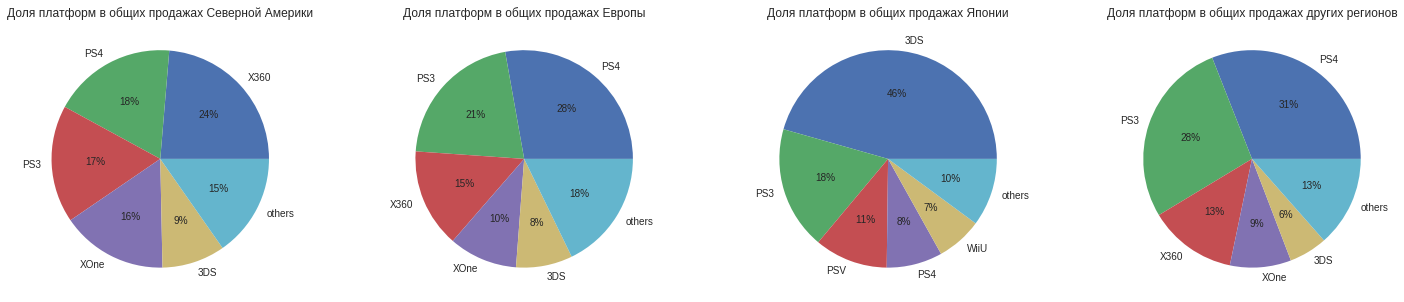

In [669]:
display(pd.DataFrame({
    'Северная Америка': list(piv_pl_na.index),
    'Европа': list(piv_pl_eu.index),
    'Япония': list(piv_pl_jp.index),
    'Другие регионы': list(piv_pl_other.index)
})[:5])


fig, ax = plt.subplots(1, 4, figsize=(25, 5))

fig.subplots_adjust(hspace=0.3)

dfs = [piv_pl_na, piv_pl_eu, piv_pl_jp, piv_pl_other]
columns = ['na_sales', 'eu_sales','jp_sales', 'other_sales']
regions = ['Северной Америки', 'Европы', 'Японии', 'других регионов']
common_title = lambda x: f'Доля платформ в общих продажах {x}'


for i in range(4):
        (dfs[i]['part_region']
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         title=common_title(regions[i]),
         ax=ax[i]))

Северная Америка Европа Япония Другие регионы
0             X360    PS4    3DS            PS4
1              PS4    PS3    PS3            PS3
2              PS3   X360    PSV           X360
3             XOne   XOne    PS4           XOne
4              3DS    3DS   WiiU            3DS

Северная Америка        Европа        Япония Другие регионы
0           Action        Action  Role-Playing         Action
1          Shooter       Shooter        Action        Shooter
2           Sports        Sports          Misc         Sports
3     Role-Playing  Role-Playing    Simulation   Role-Playing
4             Misc        Racing      Fighting           Misc

Северная Америка Европа Япония Другие регионы
0                M      M      E              M
1                E      E      T              E
2             E10+   E10+      M              T
3                T      T   E10+           E10+

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


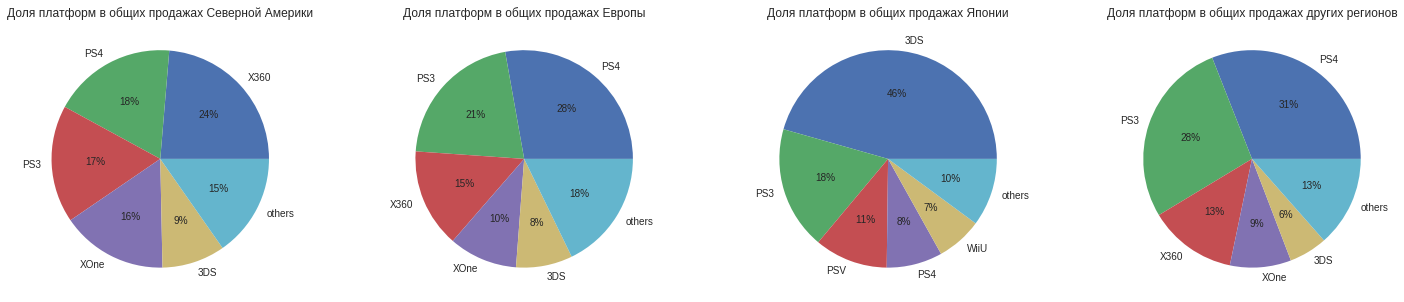

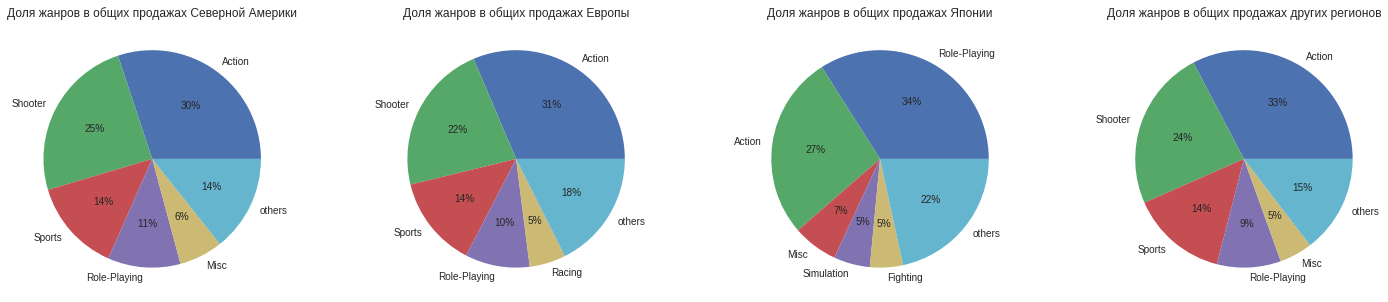

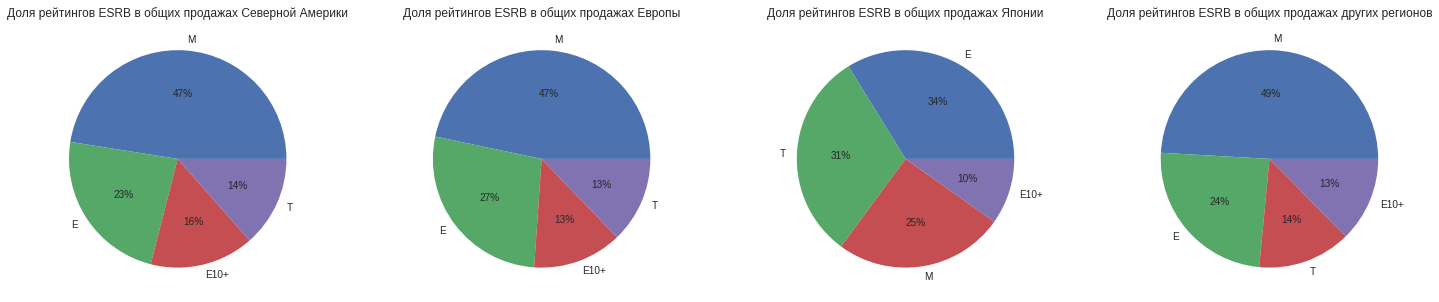

In [670]:
display(pd.DataFrame({
    'Северная Америка': list(piv_pl_na.index),
    'Европа': list(piv_pl_eu.index),
    'Япония': list(piv_pl_jp.index),
    'Другие регионы': list(piv_pl_other.index)
})[:5])


fig, ax = plt.subplots(1, 4, figsize=(25, 5))

fig.subplots_adjust(hspace=0.3)

dfs = [piv_pl_na, piv_pl_eu, piv_pl_jp, piv_pl_other]
regions = ['Северной Америки', 'Европы', 'Японии', 'других регионов']
common_title = lambda x: f'Доля платформ в общих продажах {x}'


for i in range(4):
        (dfs[i]['part_region']
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         title=common_title(regions[i]),
         ax=ax[i]))

display(pd.DataFrame({
    'Северная Америка': list(piv_genre_na.index),
    'Европа': list(piv_genre_eu.index),
    'Япония': list(piv_genre_jp.index),
    'Другие регионы': list(piv_genre_other.index)
})[:5])


fig, ax = plt.subplots(1, 4, figsize=(25, 5))

fig.subplots_adjust(hspace=0.3)

dfs = [piv_genre_na, piv_genre_eu, piv_genre_jp, piv_genre_other]
regions = ['Северной Америки', 'Европы', 'Японии', 'других регионов']
common_title = lambda x: f'Доля жанров в общих продажах {x}'


for i in range(4):
        (dfs[i]['part_region']
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         title=common_title(regions[i]),
         ax=ax[i]))
        
        
display(pd.DataFrame({
    'Северная Америка': list(piv_rating_na.index),
    'Европа': list(piv_rating_eu.index),
    'Япония': list(piv_rating_jp.index),
    'Другие регионы': list(piv_rating_other.index)
})[:4])


fig, ax = plt.subplots(1, 4, figsize=(25, 5))

fig.subplots_adjust(hspace=0.3)

dfs = [piv_rating_na, piv_rating_eu, piv_rating_jp, piv_rating_other]
regions = ['Северной Америки', 'Европы', 'Японии', 'других регионов']
common_title = lambda x: f'Доля рейтингов ESRB в общих продажах {x}'


for i in range(4):
        (dfs[i].query('part_region > 0')['part_region']
         .plot(kind='pie',
         autopct = "%.0f%%",
         ylabel= "",
         title=common_title(regions[i]),
         ax=ax[i]))

Итак, портреты составлены. Отметим, что каждый из исследуемых регионов имеет свои наиболее популярные платформы, жанры и рейтинги. Особенно отличается портрет Японии, разительные отличия от портретов Америки, Европы и других регионов.

## Проверка гипотез

In [671]:
actual_df.shape

(2886, 14)

Количество точек в датасете больше 30, значит для проверки гипотез можно использовать T-тест Стьюдента. В обеих задачах просят сравнить средние выборок (назависимых), поэтому будем применять тест `ttest_ind`

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


<div style="color:#343434 ;background-color:#FFC95F" class="alert alert-block alert-info"> 
$H_0:$ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

$H_1:$ Средние пользовательские рейтинги платформ Xbox One и PC различаются (в задании не уточняется, в какую сторону проводим тест, значит пользуемся двухсторонней проверкой)
    
Уровень значимости: $\alpha = 5\%$
    
</div>

In [672]:
alpha = .05

results = st.ttest_ind(
    actual_df.query('platform == "XOne" and user_score > 0').user_score,
    actual_df.query('platform == "PC" and user_score > 0').user_score,
)

print(f'Средний пользовательский рейтинг платформы Xbox One: {actual_df[(actual_df.platform == "XOne") & (actual_df.user_score > 0)].user_score.mean()}')
print(f'Средний пользовательский рейтинг платформы PC: {actual_df[(actual_df.platform == "PC") & (actual_df.user_score > 0)].user_score.mean()}\n')

if results.pvalue < alpha:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nH0 отвергается: Средние пользовательские рейтинги платформ Xbox One и PC значимо различаются')
else:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nНе отвергаем H0')
    

Средний пользовательский рейтинг платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг платформы PC: 6.4286407766990274

P-value = 0.5535080500643661, alpha = 0.05.

Не отвергаем H0


<div style="color:#1C315E ;background-color:#ABC270" class="alert alert-block alert-info"> 
<b>Вывод:</b> гипотеза о равенстве не была отвергнута.  
    
Можно заключить, что средние пользовательские рейтинги платформ равны. Значение P-value значимо отличается от порогового значения $\alpha$, поэтому вердикт тестирования можно считать довольно точным
</div>

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


<div style="color:#343434 ;background-color:#FFC95F" class="alert alert-block alert-info"> 
$H_0:$ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны.


$H_1:$ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные (в задании не уточняется, в какую сторону проводим тест, значит пользуемся двухсторонней проверкой)
    
Уровень значимости: $\alpha = 5\%$
    
</div>

In [673]:
alpha = .05

results = st.ttest_ind(
    actual_df.query('genre == "Action" and user_score > 0').user_score,
    actual_df.query('genre == "Sports" and user_score > 0').user_score,
)

print(f'Средний пользовательский рейтинг жанра Action: {actual_df[(actual_df.genre == "Action") & (actual_df.user_score > 0)].user_score.mean()}')
print(f'Средний пользовательский рейтинг жанра Sports: {actual_df[(actual_df.genre == "Sports") & (actual_df.user_score > 0)].user_score.mean()}\n')

if results.pvalue < alpha:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nH0 отвергается: Средние пользовательские рейтинги жанров Action и Sports значимо различаются')
else:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nНе отвергаем H0')
    

Средний пользовательский рейтинг жанра Action: 6.825047801147227
Средний пользовательский рейтинг жанра Sports: 5.455897435897437

P-value = 3.7163089460934874e-26, alpha = 0.05.

H0 отвергается: Средние пользовательские рейтинги жанров Action и Sports значимо различаются


<div style="color:#1C315E ;background-color:#ABC270" class="alert alert-block alert-info"> 
<b>Вывод:</b> гипотеза о равенстве была отвергнута. Средние рейтинги пользователей для игр в этих жанрах значимо различаются, малое значение P-value подтверждает надежность тестирования
    
Средние пользовательские рейтинги жанров Action и Sports значимо различаются
</div>

Проверим, в какую сторону различаются средние

<div style="color:#343434 ;background-color:#FFC95F" class="alert alert-block alert-info"> 
$H_0:$ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны.


$H_1:$ Средний пользовательский рейтинг жанра Action больше чем Средний пользовательский рейтинг жанра Sports
    
Уровень значимости: $\alpha = 5\%$
    
</div>

In [674]:
alpha = .05

results = st.ttest_ind(
    actual_df.query('genre == "Action" and user_score > 0').user_score,
    actual_df.query('genre == "Sports" and user_score > 0').user_score,
    alternative='greater'
)

print(f'Средний пользовательский рейтинг жанра Action: {actual_df[(actual_df.genre == "Action") & (actual_df.user_score > 0)].user_score.mean()}')
print(f'Средний пользовательский рейтинг жанра Sports: {actual_df[(actual_df.genre == "Sports") & (actual_df.user_score > 0)].user_score.mean()}\n')

if results.pvalue < alpha:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nH0 отвергается')
else:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nНе отвергаем H0')
    

Средний пользовательский рейтинг жанра Action: 6.825047801147227
Средний пользовательский рейтинг жанра Sports: 5.455897435897437

P-value = 1.8581544730467437e-26, alpha = 0.05.

H0 отвергается


<div style="color:#1C315E ;background-color:#ABC270" class="alert alert-block alert-info"> 
<b>Вывод:</b> гипотеза о равенстве была отвергнута. Средние рейтинги пользователей для игр в этих жанрах значимо различаются, малое значение P-value подтверждает надежность тестирования
    
Можно заключить, что средние пользовательские рейтинги жанра Action больше чем средний пользовательский рейтинг жанра Sports
</div>

- Средние пользовательский оценки Xbox One и PC приблизительно равны
- Средние пользовательские рейтинги жанра Action больше чем средние пользовательские рейтинги жанра Sports

## Итоговый вывод

- Изучили данные
- Привели названия столбцов к нижнему регистру
- Проанализировали исходные гистограммы
1. Исходные данные по продажам имеют сильный пик в области малых значений
2. Гистограмма по `critic_score` имеет несколько локальных максимумов. 
3. По гистограмме `year_of_release` видно, что мы имеем дело с данными примерно с 1980 по 2015 год. Есть несколько локальных максимумов

- Проанализировали пропуски

1. Более 50% значений в столбце `critic_score` - пропуски
2. Также около 40% пропущенных значений в столбцах `rating` и `user_score`
3. Меньше всего пропусков в столбцах `genre` и `name`
4. Выявили зависимость между пропусками `critic_score`, `user_score` и `rating`
5. В силу огромного количества пропусков непрерывные значения заменили на индикаторные (-1), чтобы продолжить корректное исследование

- Заменили значение tbd на -1 в столбце `user_score`
- Проверили на явные дубликаты. В столбце `name` их много, но они означают, что игры выпускались под разные платформы
- Исследовали аномальные значения продаж и оценок. 
- Построили портрет по регионам самых продаваемых и популярных игр и платформ
---
<b>Северная Америка</b>
1. Аномальные продажи игры `Wii Sports` превалируют среди других игр
2. Лучший год по количеству выпущенных и самых продаваемых игр - 2006 год
3. Среди самых продаваемых игр преобладает платформа `Wii`, вторая по популярности - `GB`
4. Среди самых продаваемых игр преобладают жанры `Platform` и `Sports`

<b>Европа</b>
1. Аналогична, игра `Wii Sports` пользуется наибольшим спросом
2. Однако наиболее удачный год выпуска по самым продаваемым играм - 2009
3. Почти половина из ТОП-15 самых продаваемых игр выпускалось под плтформу `Wii`, вторая по популярности - `DS`
4. Среди самых продаваемых игр преобладают жанры `Sports` и `Racing`

<b>Япония</b>
1. Совершенно другая игра - `pokemon red/ pokemon blue` - пользуется наибольшим спросом
2. Наиболее частый год выпуска самых продаваемых игр - 2005, 2006, 2009, 2010
3. Почти половина из ТОП-15 самых продаваемых игр выпускалось под плтформу `DS`, вторая по популярности - `GB`
4. Среди самых продаваемых самые популярные в жанре `Role-playing`, второй по популярности жанр - `platform`

<b>Другие регионы</b>
1. Наиболее высоким спросом пользуется игра `Grand Theft Auto: San Andreas`
2. Наиболее частый год выпуска самых продаваемых игр - 2006 и 2007
3. Почти половина из ТОП-15 самых продаваемых игр выпускалось под плтформу `Wii`, вторая по популярности - `PS2`
4. Среди самых продаваемых самые популярные в жанре `Sports`, второй по популярности жанр - `action`
---
- Отдельно исследовали столбцы c оценками, рейтингом и платформой
1. Наиболее популярны платформы PS2 и DS
2. Около 40% игр выпущено под платформы PlayStation


3. Превалирует рейтинг `E` (для всех)
4. Также популярны рейтинги `T` (для подростков) и `M` (для взрослых)


5. Действительно низких оценок пользователей достаточно мало
6. Больше всего низких оценок поставлено пользователями играм на платформе X360 и PS3
7. Самая низко оцененная пользователями игра - Angry Birds Star Wars. Причем и критики оценили ее не высоко (до 60 баллов)
8. Оценки пользователей имеют довольно любопытную связь, их коэффициент корреляции около 0.6


9. Очень низких оценок критиков достаточно мало
10. Больше всего низких оценок поставлено критиками играм на платформе Wii и X360
11. Самая низко оцененная критиками игра - Call of Duty (Modern Warfare 3, Ghosts). Причем и пользователи оценили их не высоко (до 5 баллов)


- Проанализировали количество игр по годам выпуска

1. До 1991 года игр почти не было, как и их продаж. Поэтому период до 1991 года можно не рассматривать
2. Далее популярность игр возрастала до небольшого спада в 1999-2000
3. Затем резкий скачок - эпоха PlayStation1-2
4. Самый большой пик популярности - 2008-2009 года
5. Период примерно с 2011 по 2016 нам точно будет интересен, так как он актуальнее всего

- Проанализировали популярность платформ по годам. Вычислили характерный цикл консоли (время активности) - около 10 лет
- На основе цикла консоли определили актуальный период (2012-2016)
- Выявили перспективные платформы - Xbox One и PS4 - на основе графиков продаж и их производной
- Оценили распределение суммарных продаж по платформам актуального периода
- Посмотрели влияние оценок критиков и пользователей на суммарные продажи

1. Для почти всех популярных платформ большее справедливо, что большее влияние на продажи имеет оценка критиков. Причем разница между уровнем влияния весьма существенная. Для платформы WiiU наблюдается иная ситуация, во-первых оба коэффициента корреляции больше 0.35, во-вторых отзывы пользователей оказывают большее влияние на суммарные продажи
2. При этом влияние оценки ограничено коэффициентом корреляции в 0.42
3. Наибольшее влияние критическое мнение оказывает на продажи игр, выпущенных под платформу XOne, наименьшее - на игры под платформу 3DS

- Выявили самый популярный жанр актуального периода

1. Больше всего было продано игр в жанре Action, наименьшие суммарные продажи игр были осуществлены в жанре Puzzle
2. Однако самым успешным стал жанр Shooter, его медианные продажи значимо превышают медианные продажи других жанров


То есть на 2017 год следует подумать о большем выпуске игр в жанре Shooter и Sports


- Построили характерные портреты регионов по факторам (топ-5 платформ, топ-5 популярных жанров, влияние рейтинга ESRB). Выявили, что выбивается из общей картины характерный портрет Японии
- Проверили гипотезы о средних значениях суммарных продаж

1. Средние пользовательский оценки Xbox One и PC приблизительно равны
2. Средние пользовательские рейтинги жанра Action больше чем средние пользовательские рейтинги жанра Sports